<a href="https://colab.research.google.com/github/xelothi/ML-for-kinase-inhibitors-development/blob/main/clustering_algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
! pip install rdkit

In [38]:
! pip install mols2grid

In [106]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, Descriptors, rdFingerprintGenerator, AllChem, MACCSkeys
import numpy as np
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
import mols2grid
from IPython.display import display
from rdkit.Chem.rdFMCS import FindMCS
import matplotlib.image as mpimg

In [40]:
df = pd.read_csv("CRAF_cleaned_and_preprocessed_data.csv", index_col=[0])
df.head()

,molecule_chembl_id,std_smiles,MW,LogP,NumHDonors,NumHAcceptors,numRotatingBonds,norm_value,pIC50,bioactivity
0,CHEMBL18754,CNC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(C)cc1,345.468,4.35762,3.0,3.0,3.0,4900.0,5.309804,active
1,CHEMBL279560,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(O)cc1,348.424,4.18180,3.0,5.0,3.0,15000.0,4.823909,active
2,CHEMBL95114,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccn(C(C)C)n1,364.471,4.25360,2.0,6.0,4.0,16000.0,4.795880,active
3,CHEMBL279377,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(C)cc1,346.452,4.78462,2.0,4.0,3.0,1700.0,5.769551,active
4,CHEMBL95692,COc1nccc(-c2c(-c3ccc(F)cc3)ncn2C2CCNCC2)n1,353.401,3.07930,1.0,6.0,4.0,50.0,7.301030,inactive


In [41]:
df.dropna()

,molecule_chembl_id,std_smiles,MW,LogP,NumHDonors,NumHAcceptors,numRotatingBonds,norm_value,pIC50,bioactivity
0,CHEMBL18754,CNC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(C)cc1,345.468,4.35762,3.0,3.0,3.0,4900.00,5.309804,active
1,CHEMBL279560,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(O)cc1,348.424,4.18180,3.0,5.0,3.0,15000.00,4.823909,active
2,CHEMBL95114,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccn(C(C)C)n1,364.471,4.25360,2.0,6.0,4.0,16000.00,4.795880,active
3,CHEMBL279377,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(C)cc1,346.452,4.78462,2.0,4.0,3.0,1700.00,5.769551,active
4,CHEMBL95692,COc1nccc(-c2c(-c3ccc(F)cc3)ncn2C2CCNCC2)n1,353.401,3.07930,1.0,6.0,4.0,50.00,7.301030,inactive
...,...,...,...,...,...,...,...,...,...,...
1699,CHEMBL5088891,CC1(C)CN(CCNc2nccc(-c3c(-c4cccc(O)c4)nc4sccn34...,485.595,2.56590,3.0,9.0,6.0,4.26,8.370590,inactive
1700,CHEMBL5079413,CN1CCCN(CCNc2nccc(-c3c(-c4cccc(O)c4)nc4sccn34)...,485.595,2.51960,2.0,9.0,6.0,1.96,8.707744,inactive
1701,CHEMBL5076688,O=S1(=O)NCCN1CCNc1nccc(-c2c(-c3cccc(O)c3)nc3sc...,457.541,1.78730,3.0,9.0,6.0,6.32,8.199283,inactive
1702,CHEMBL5079502,O=S1(=O)NCCCN1CCNc1nccc(-c2c(-c3cccc(O)c3)nc3s...,471.568,2.17740,3.0,9.0,6.0,7.21,8.142065,inactive


#Calculating the number of bits that should be used

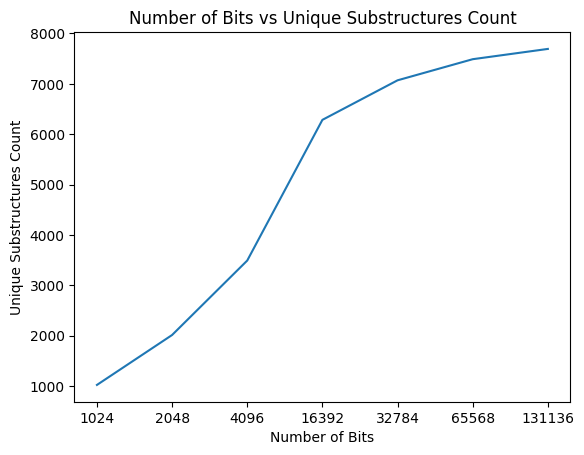

In [42]:
num_of_bits = [1024, 2048, 4096, 16392, 32784,65568,131136]
mols = [Chem.MolFromSmiles(smiles) for smiles in df['std_smiles']]  # Convert SMILES strings to RDKit molecules
uniques = []
for bit in num_of_bits:
    FPs = []
    infos = []
    for mol in mols:
        info = {}
        FPs.append(AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=bit, bitInfo=info, useFeatures=True))
        infos.append(info)
    uniques.append(np.logical_or.reduce(FPs).sum())

fig, ax = plt.subplots()
ax.plot(uniques)

# Set custom tick labels on the X-axis
plt.xticks(range(len(num_of_bits)), num_of_bits)

ax.yaxis.get_major_locator().set_params(integer=True)
plt.xlabel("Number of Bits")
plt.ylabel("Unique Substructures Count")
plt.title("Number of Bits vs Unique Substructures Count")

plt.show()

In [43]:
uniques

[1024, 2015, 3493, 6285, 7070, 7489, 7693]

# Butina clustering

RDKit fingeprints butina clustering

In [44]:
mols = []
for _, chembl_id, smiles in df[["molecule_chembl_id", "std_smiles"]].itertuples():
    mols.append((Chem.MolFromSmiles(smiles), chembl_id))
RDKFingerprints = []
MorganFingerprints = []
MACCS = []

for m,id in mols:
    RDKFingerprints.append(Chem.RDKFingerprint(m, maxPath=5))
    MorganFingerprints.append(AllChem.GetMorganFingerprintAsBitVect(m, 3, nBits=32784, useFeatures=True))
    MACCS.append(MACCSkeys.GenMACCSKeys(m))


Tanimoto similarity distance matrix

In [45]:
# generate distance matrix using tanimoto
def tan_distance_matrix(fp):
  dist_matrix = []
  num_fps = len(fp)
  for i in range(1, num_fps):
    similarities = DataStructs.BulkTanimotoSimilarity(fp[i], fp[:i])
    dist_matrix.extend([1 - x for x in similarities])
  return dist_matrix

Dice similarity distance matrix

In [46]:
# generate distance matrix using Dice similarity
def dice_distance_matrix(fp):
  dist_matrix = []
  num_fps = len(fp)
  for i in range(1, num_fps):
    similarities = DataStructs.BulkDiceSimilarity(fp[i], fp[:i])
    dist_matrix.extend([1 - x for x in similarities])
  return dist_matrix


In [47]:
# cluster
def cluster(fp,dist_matrix, cutoff):
  num_fps = len(fp)
  clusters = Butina.ClusterData(dist_matrix, num_fps, cutoff, isDistData=True)
  return clusters

In [48]:
  def plot_clusters(fingerprints, dist_matrix, cutoff_range=(0.0, 1.0, 0.1)):
    for cutoff in np.arange(*cutoff_range):
        clusters = cluster(fingerprints, dist_matrix, cutoff)
        fig, ax = plt.subplots(figsize=(15, 4))
        ax.set_title(f"Threshold: {cutoff:3.1f}")
        ax.set_xlabel("Cluster index")
        ax.set_ylabel("Number of molecules")
        ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)
        plt.show()

Calculating tanimoto distance matrix for all of our fingerprints

In [49]:
RDKFingerprints_tan_dist_matrix = tan_distance_matrix(RDKFingerprints)
MorganFingerprints_tan_dist_matrix = tan_distance_matrix(MorganFingerprints)
MACCS_tan_dist_matrix = tan_distance_matrix(MACCS)

Butina clustering using tanimoto distance matrix

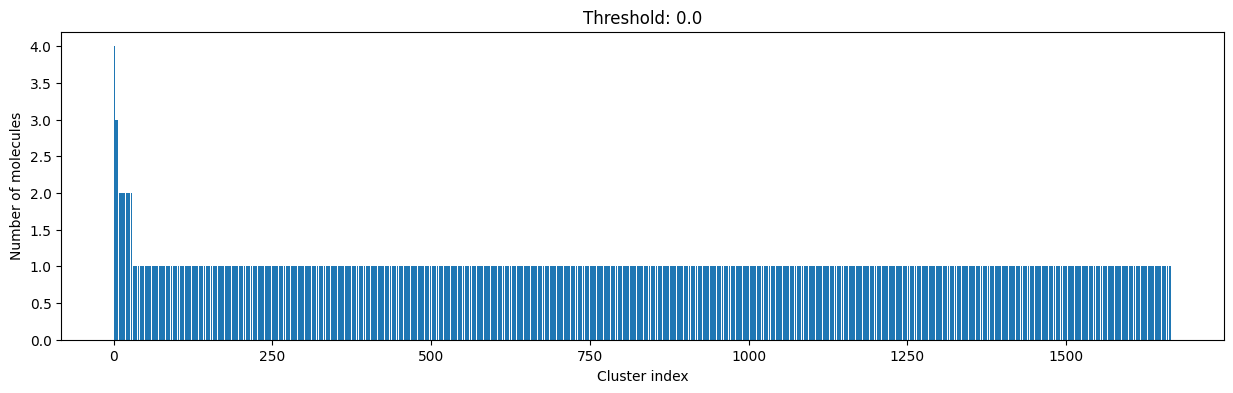

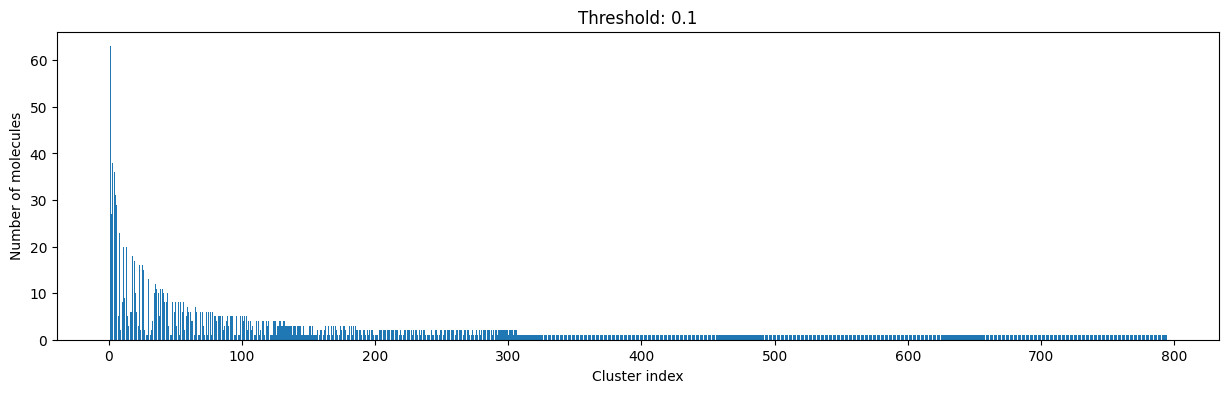

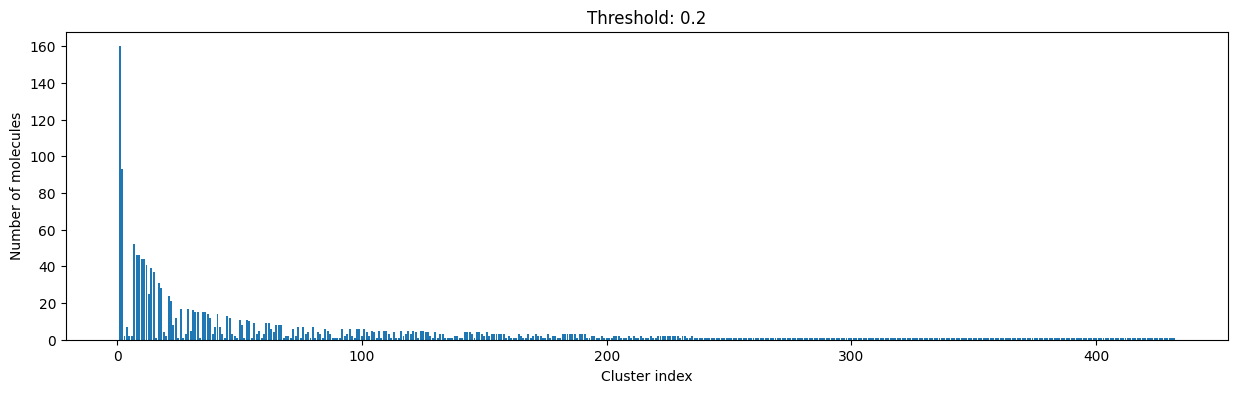

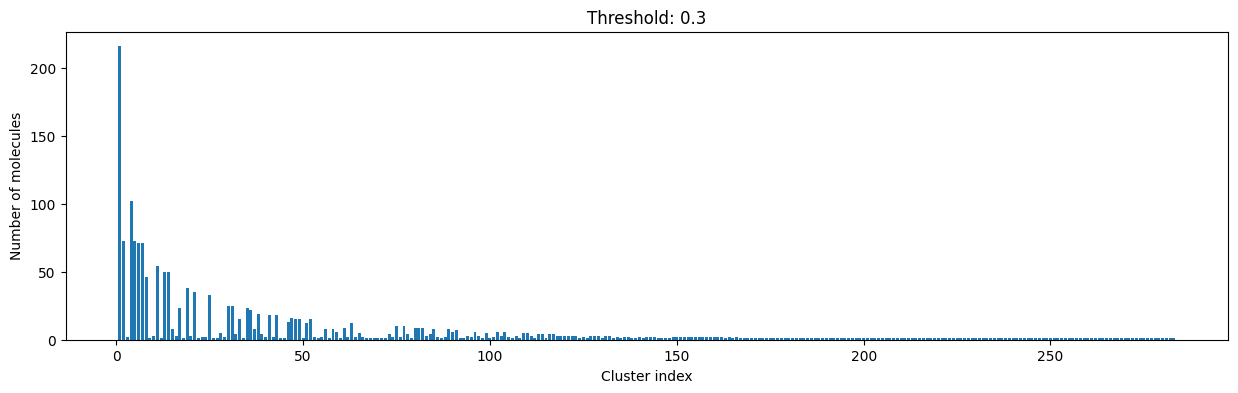

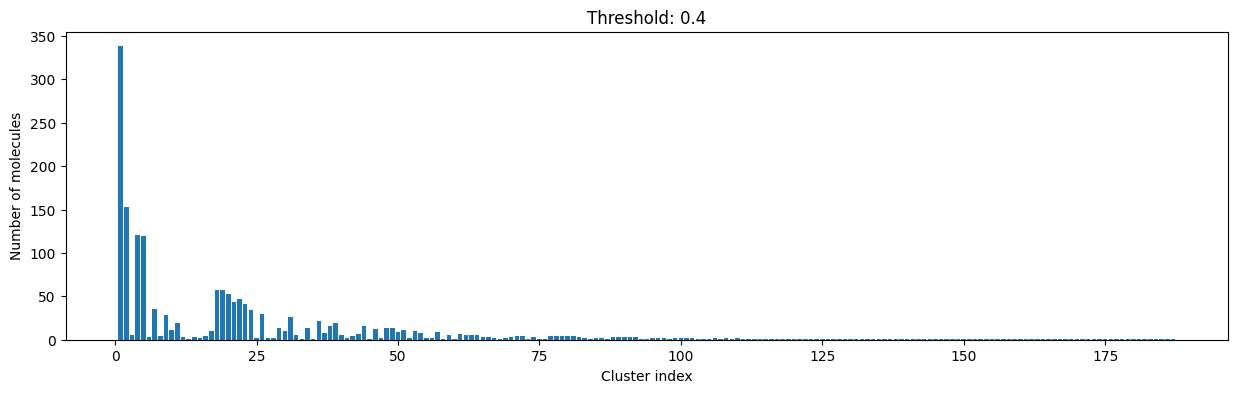

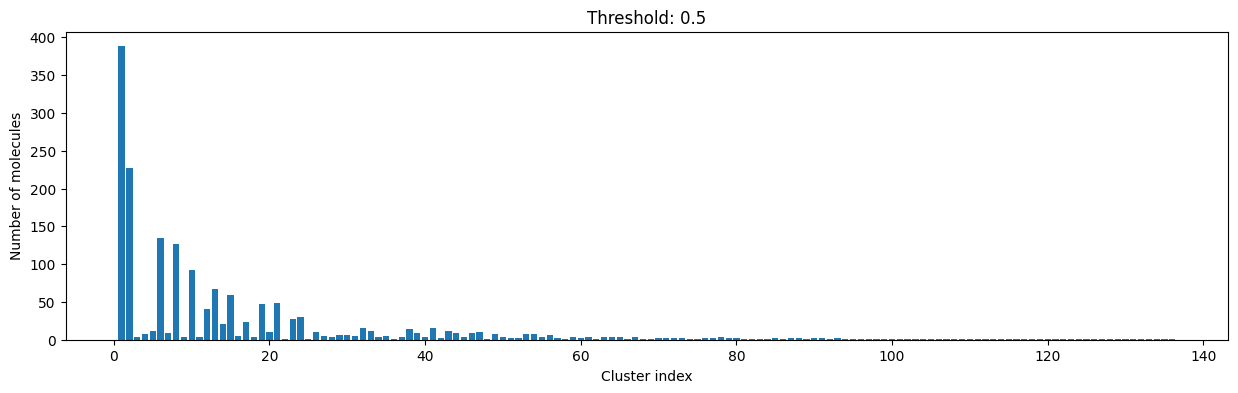

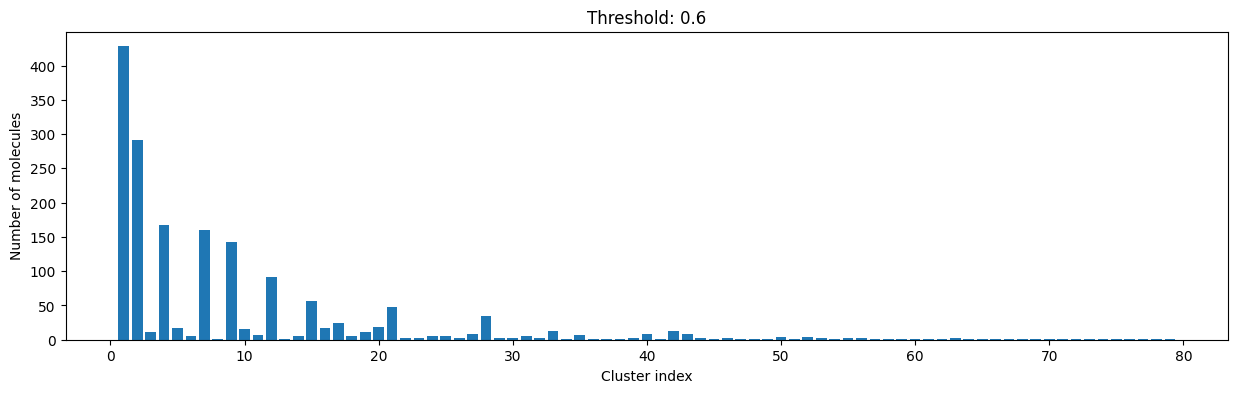

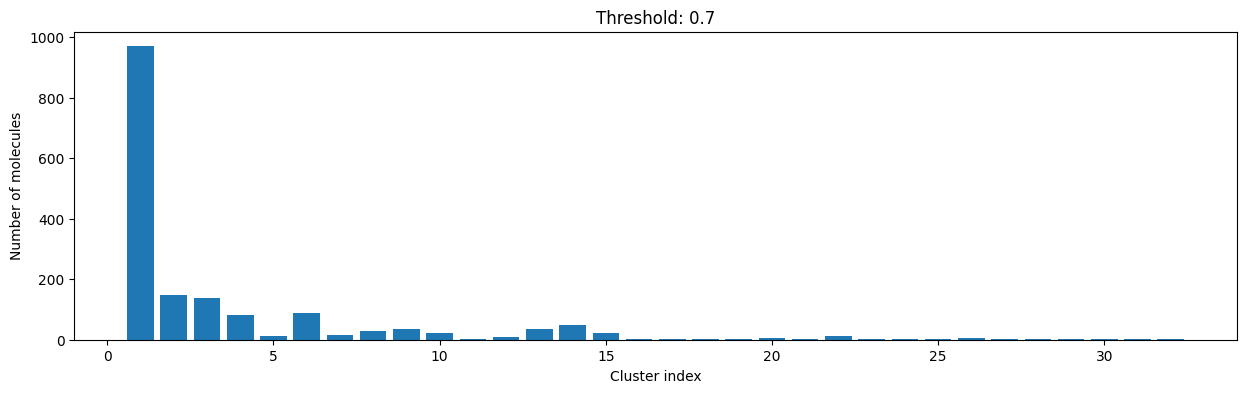

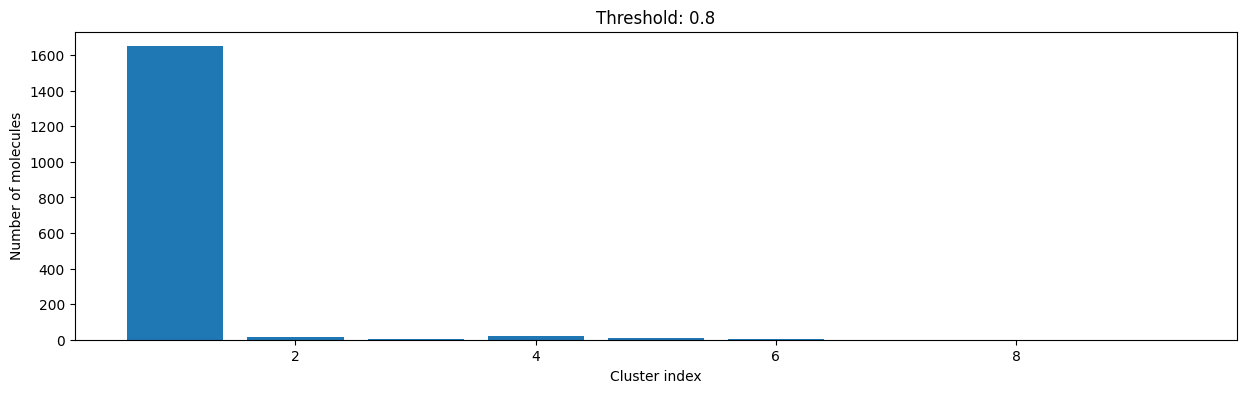

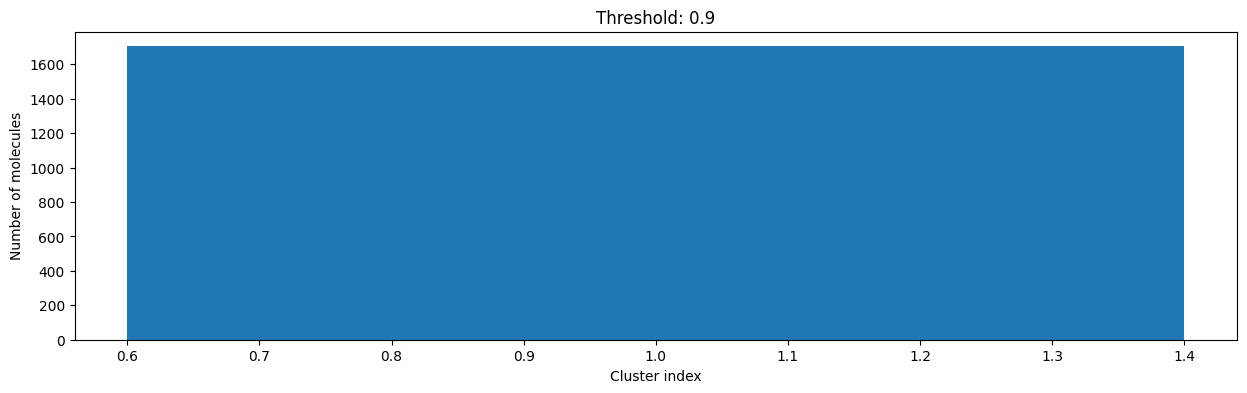

In [50]:
plot_clusters(RDKFingerprints, RDKFingerprints_tan_dist_matrix)

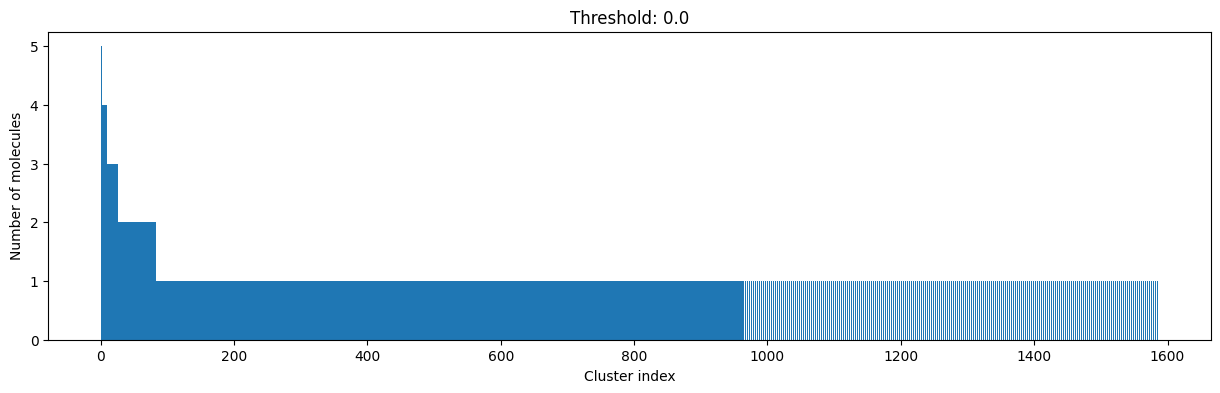

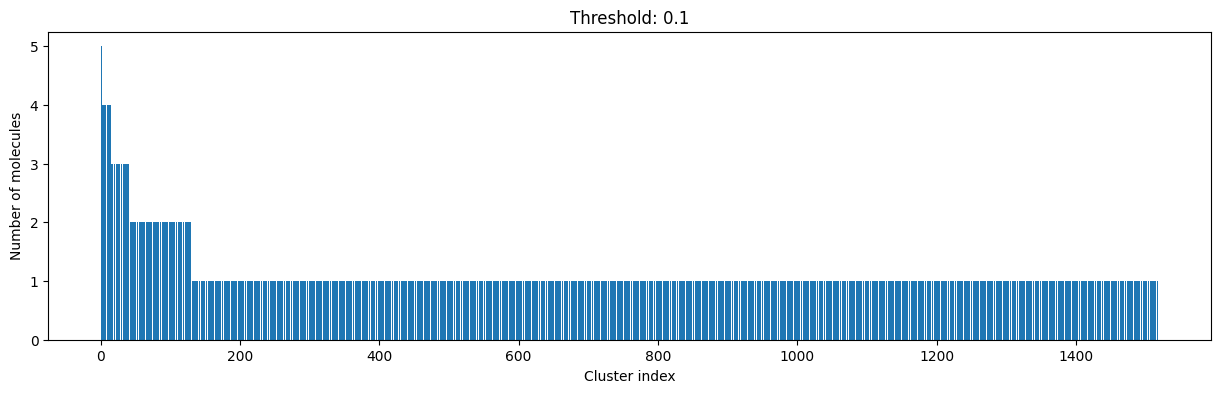

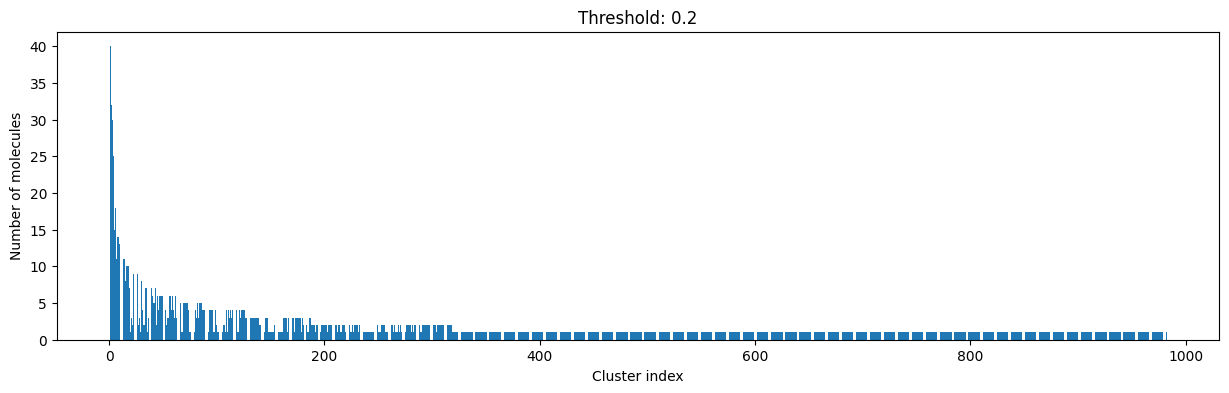

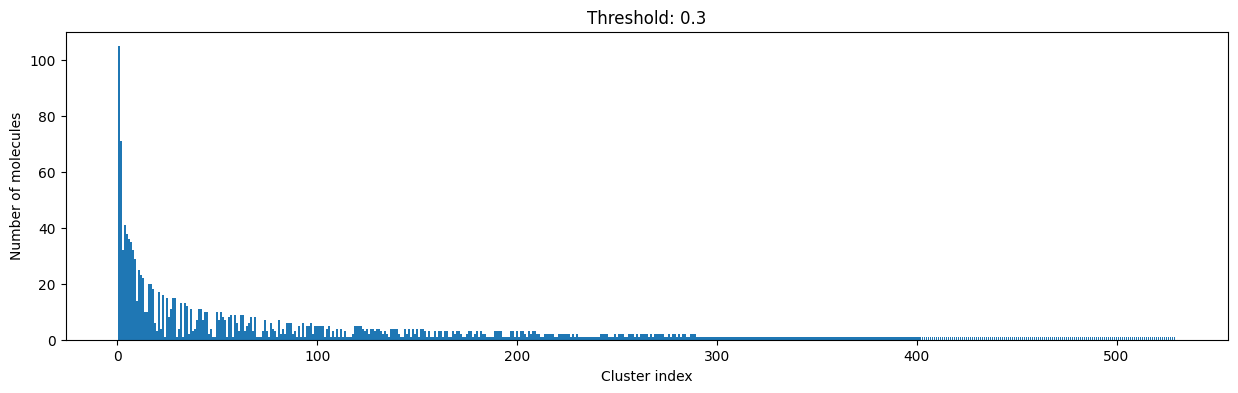

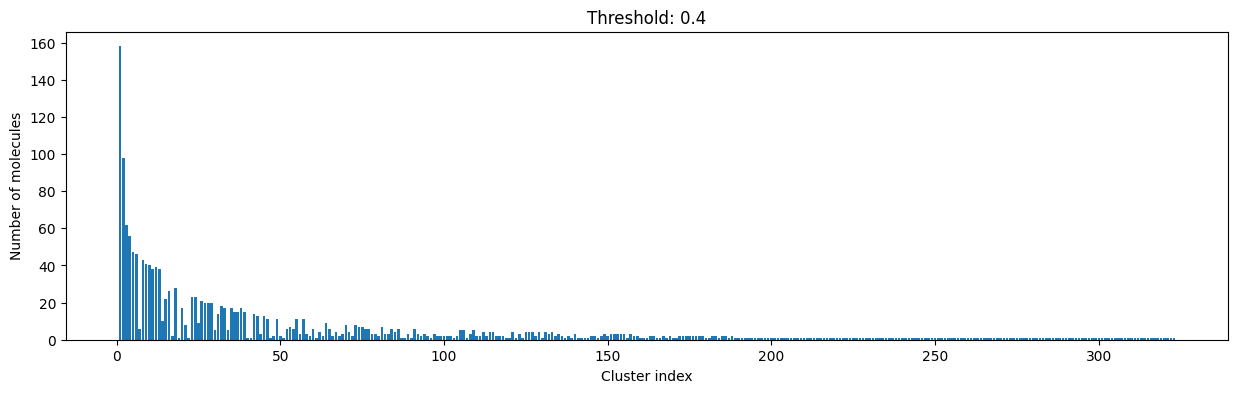

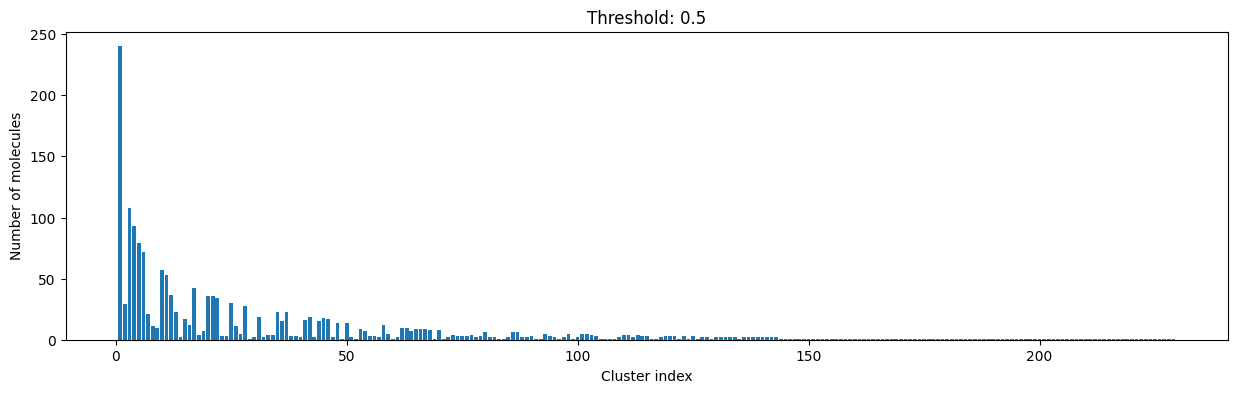

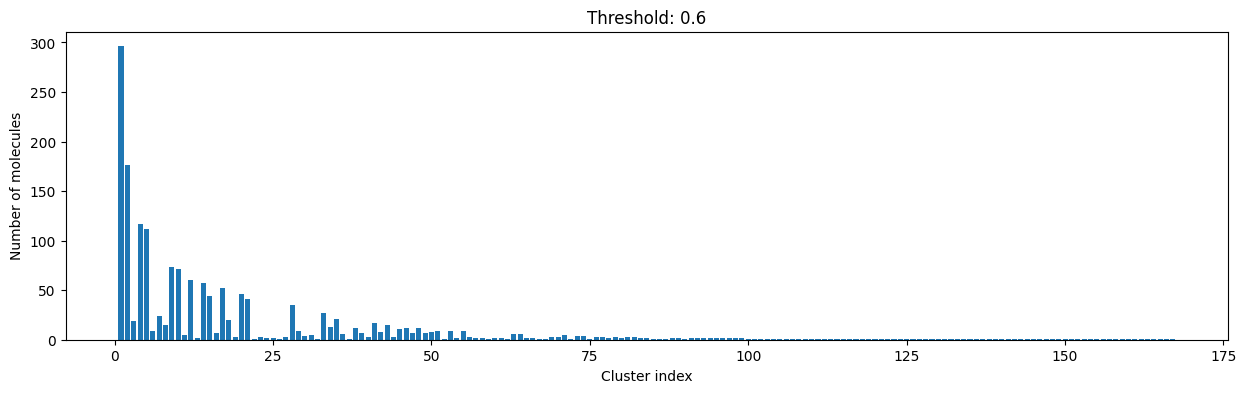

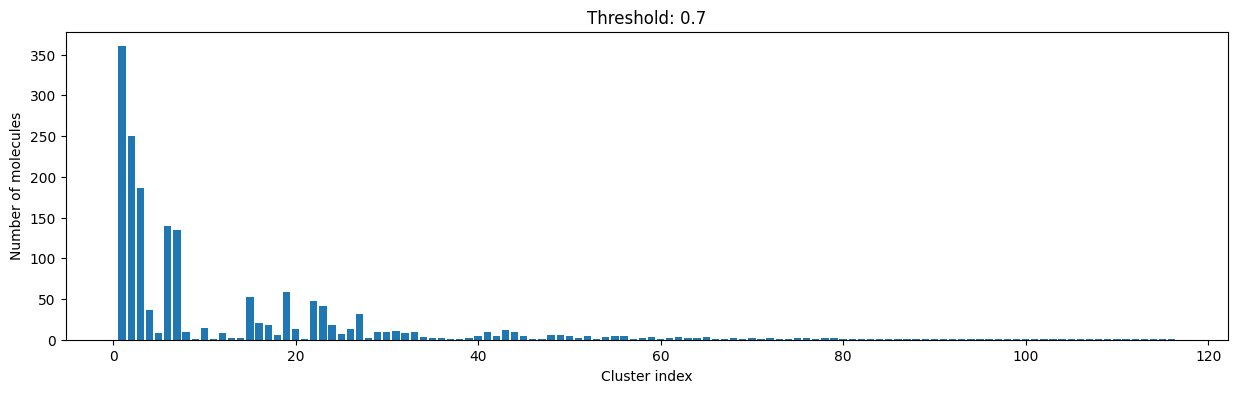

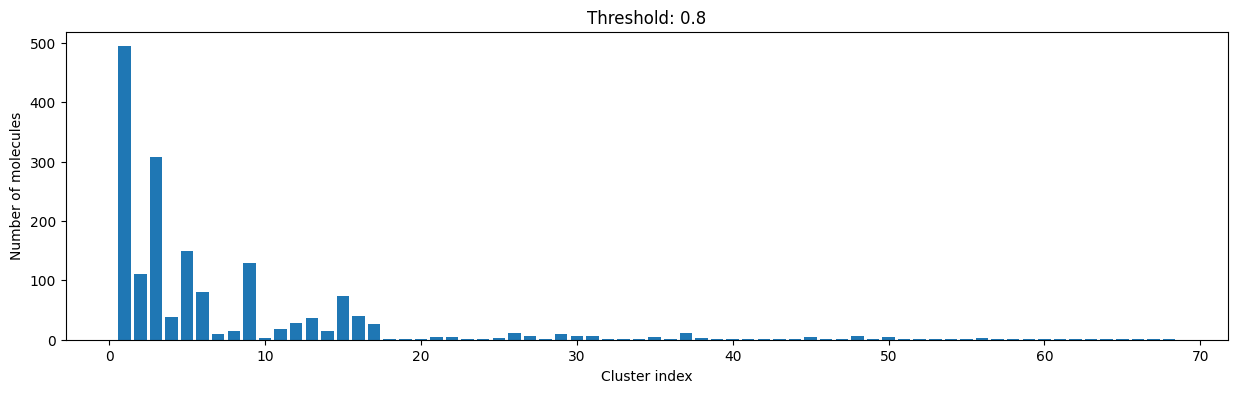

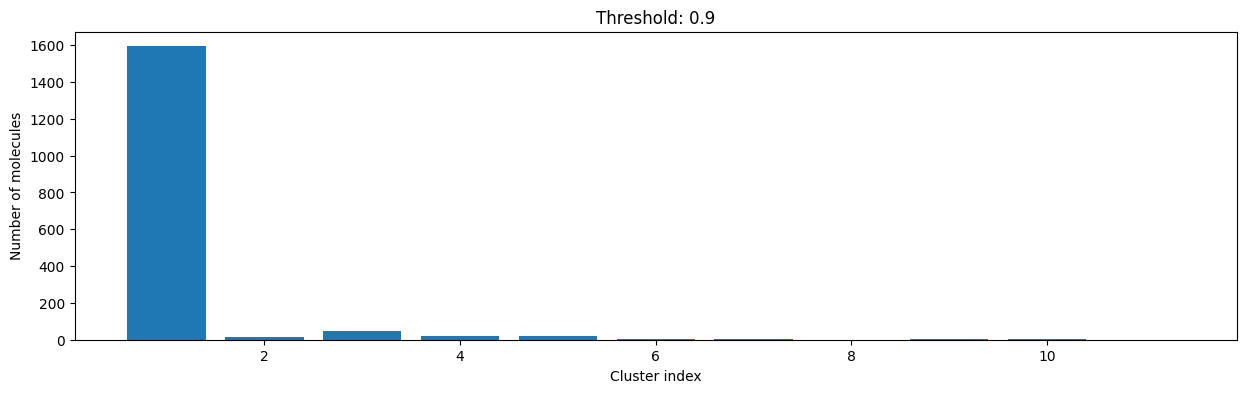

In [53]:
plot_clusters(MorganFingerprints, MorganFingerprints_tan_dist_matrix)

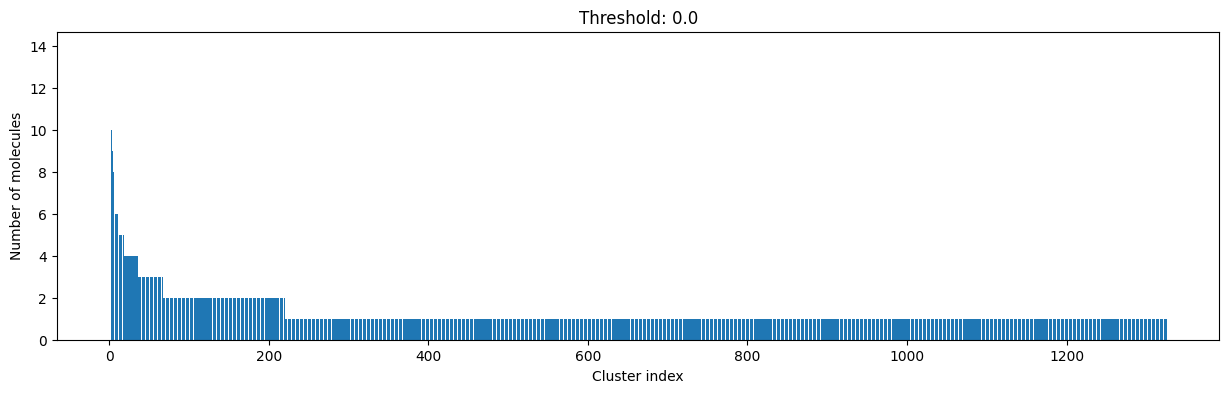

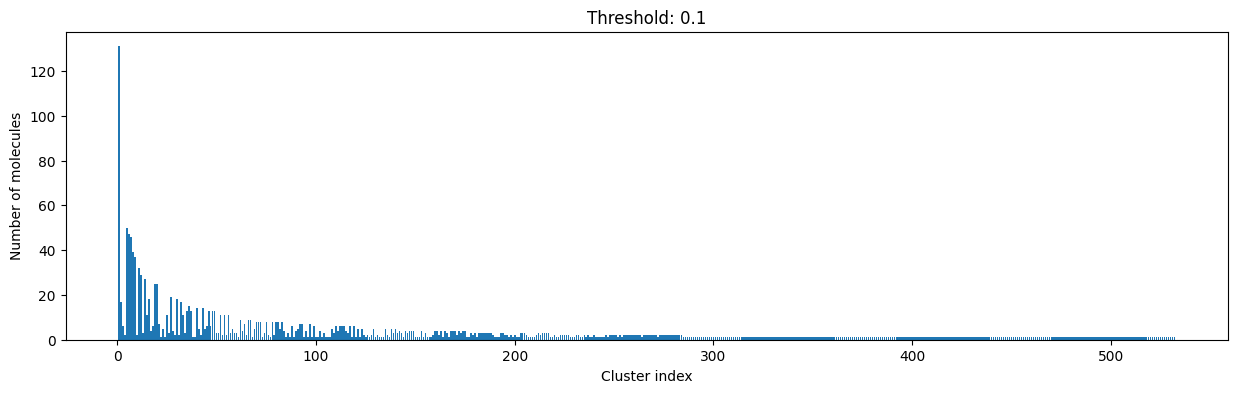

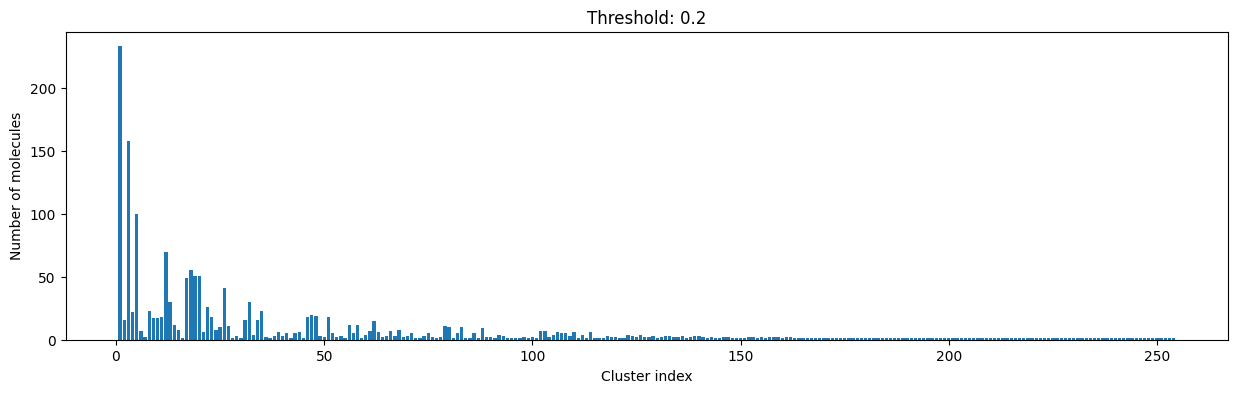

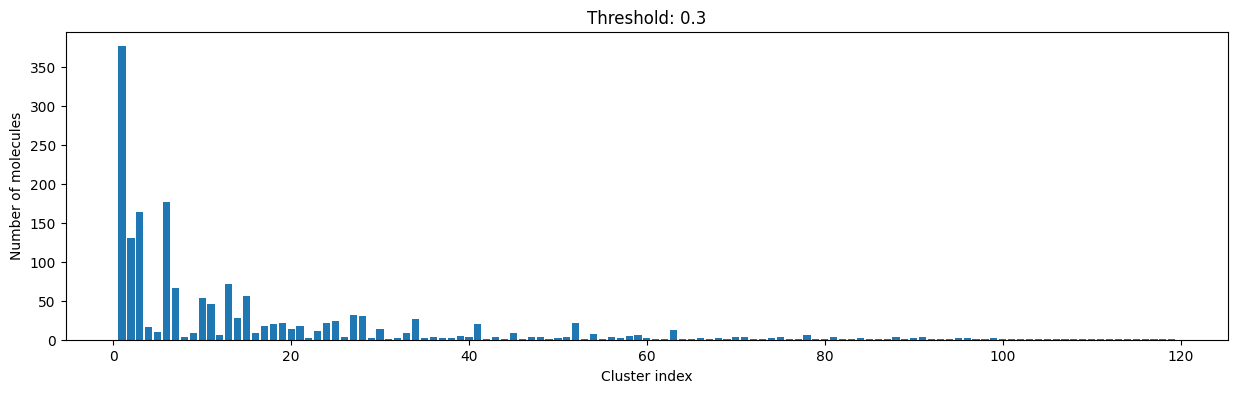

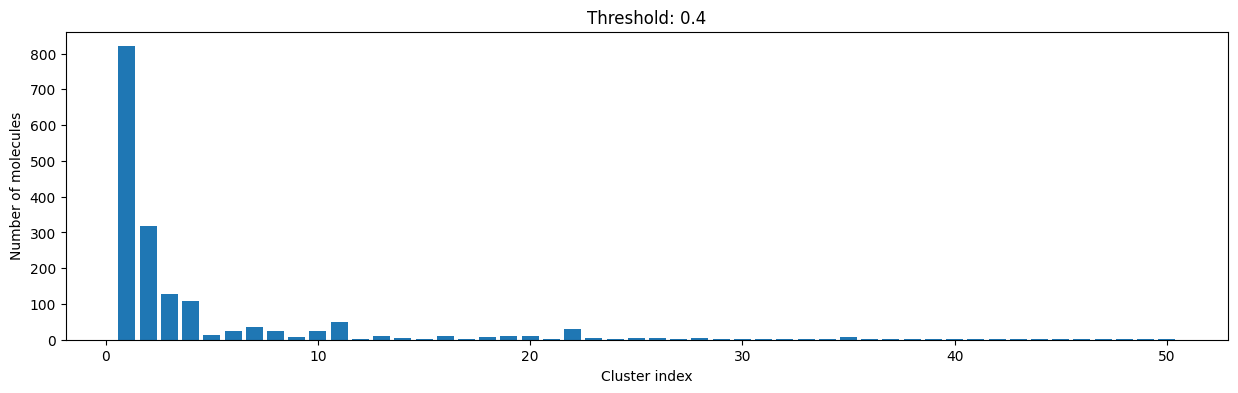

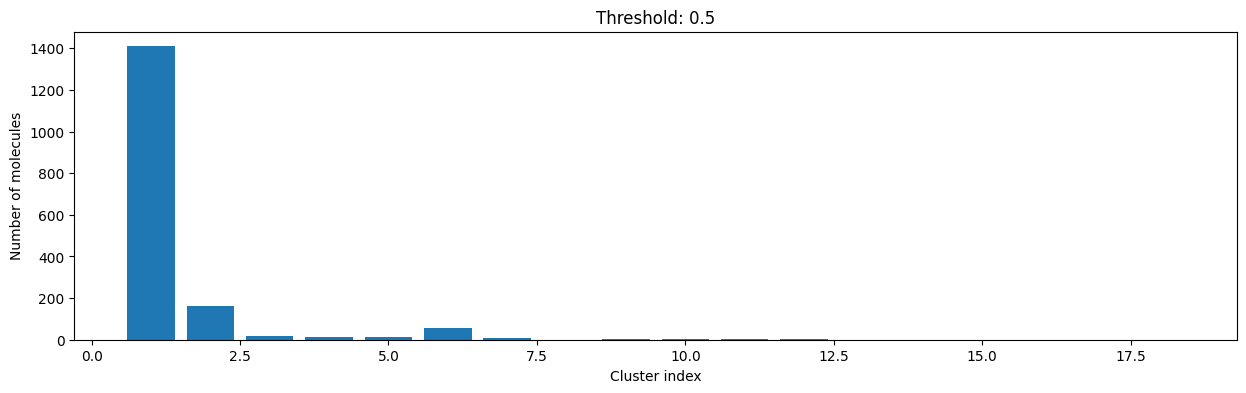

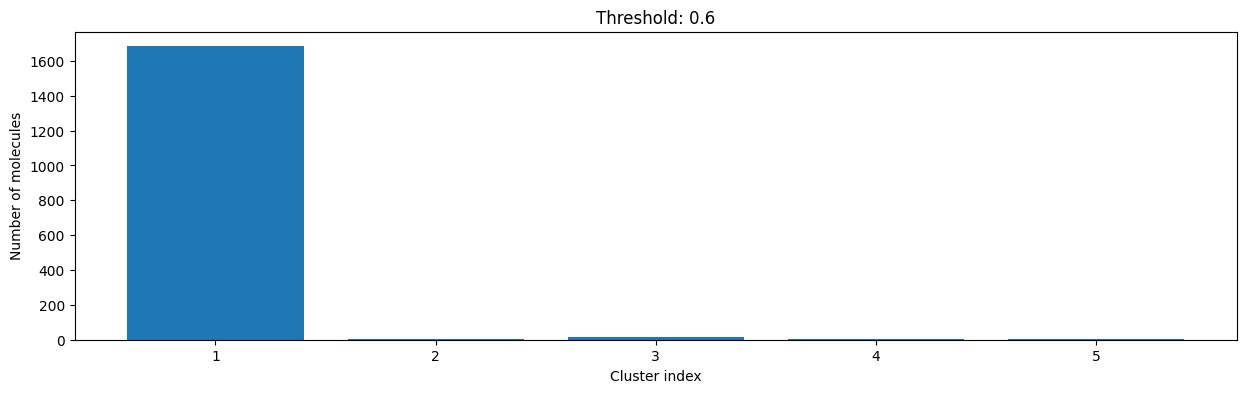

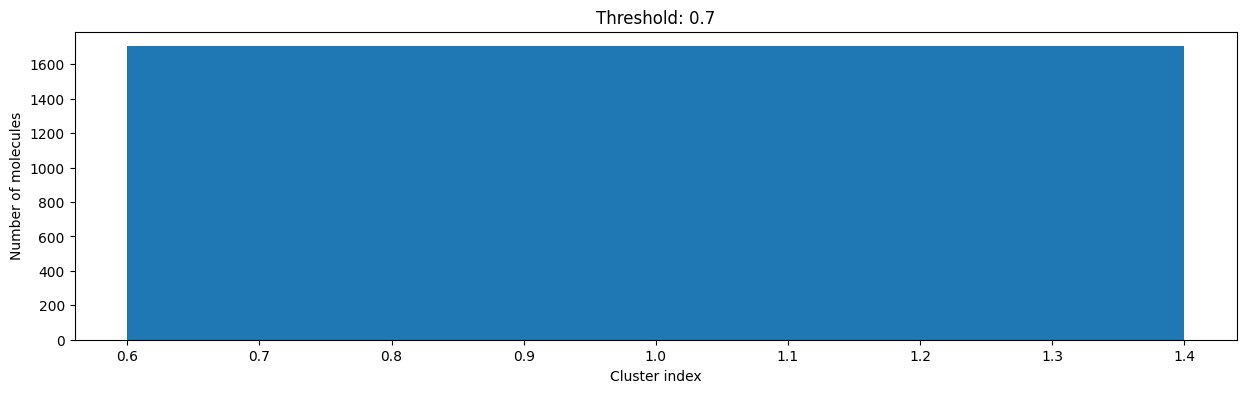

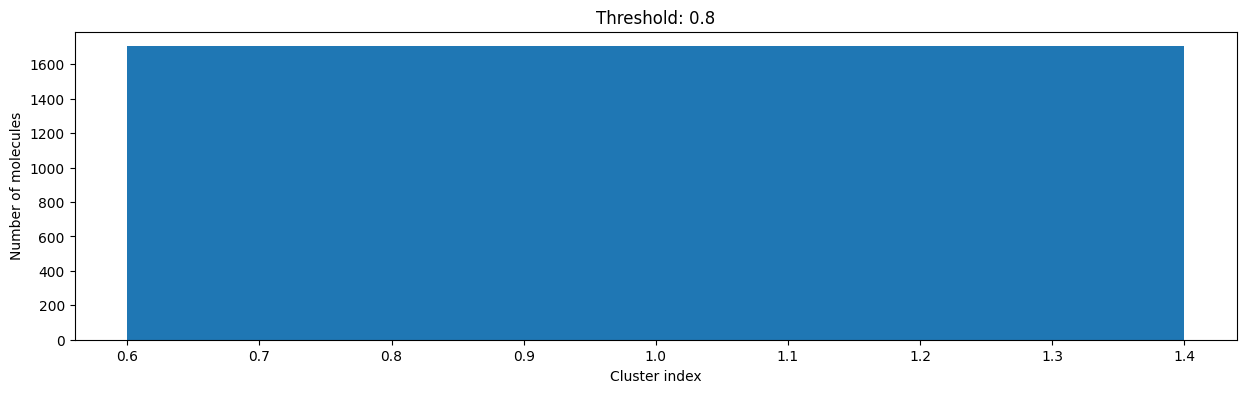

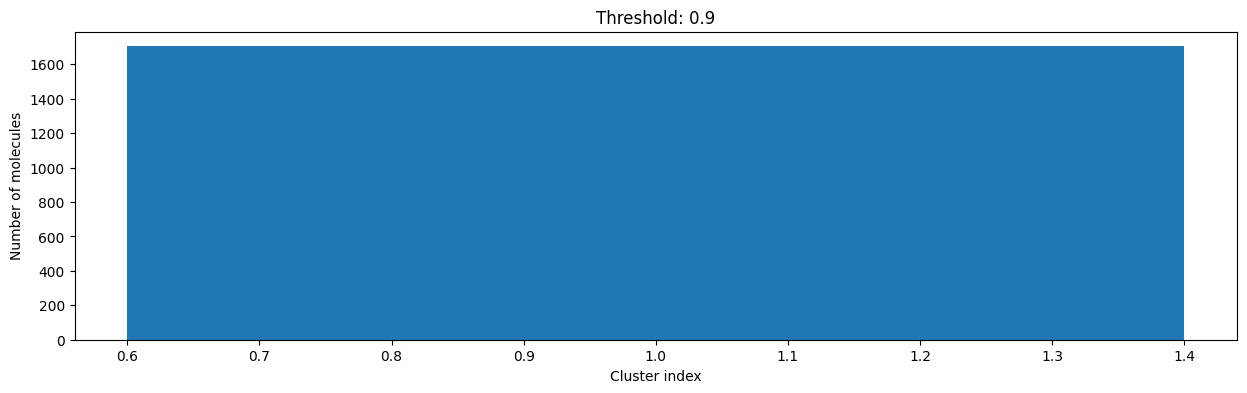

In [54]:
plot_clusters(MACCS, MACCS_tan_dist_matrix)

In [57]:
RDKFingerprints_tan_cluster = cluster(RDKFingerprints, RDKFingerprints_tan_dist_matrix, cutoff=0.2)
MorganFingerprints_tan_cluster = cluster(MorganFingerprints, MorganFingerprints_tan_dist_matrix, 0.3)
MACCS_tan_cluster = cluster(MACCS, MACCS_tan_dist_matrix,0.1)

Butina clustering for dice distance matrix

In [58]:
RDKFingerprints_dice_dist_matrix = dice_distance_matrix(RDKFingerprints)
MorganFingerprints_dice_dist_matrix = dice_distance_matrix(MorganFingerprints)
MACCS_dice_dist_matrix = dice_distance_matrix(MACCS)

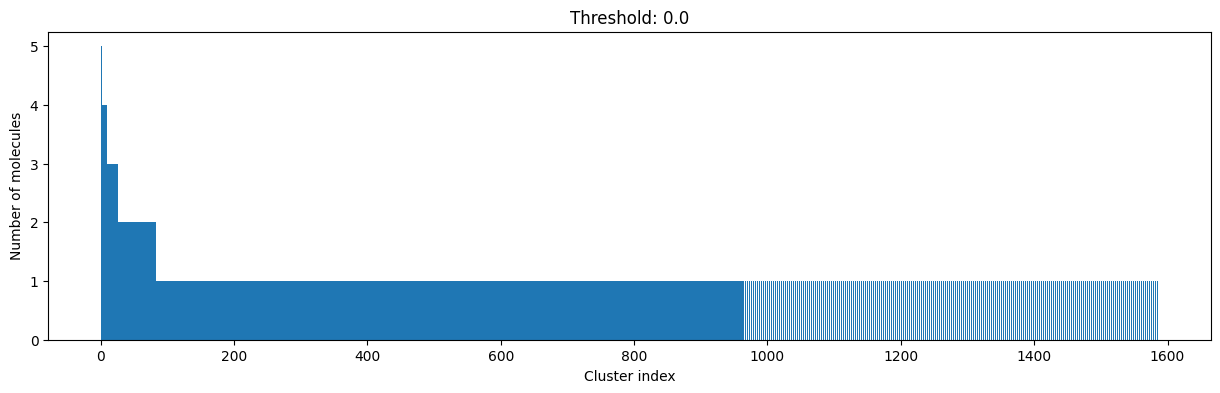

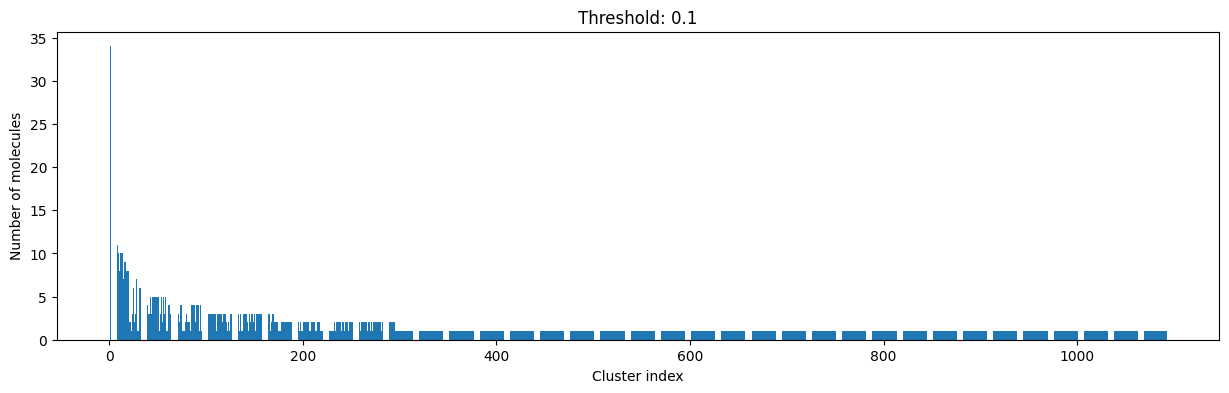

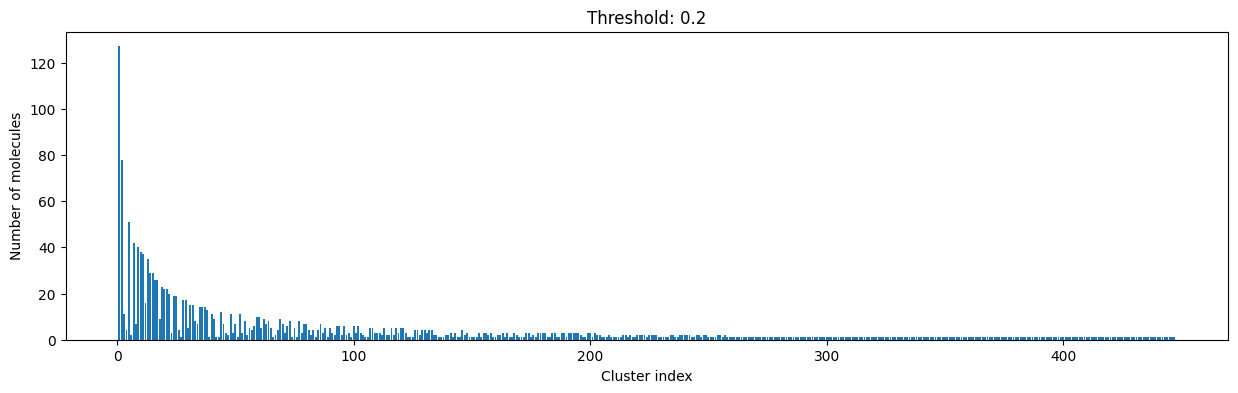

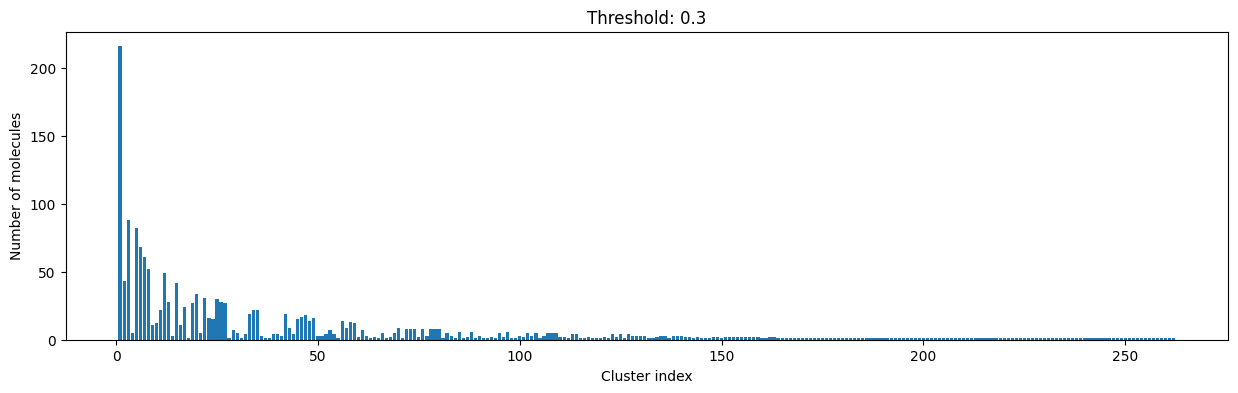

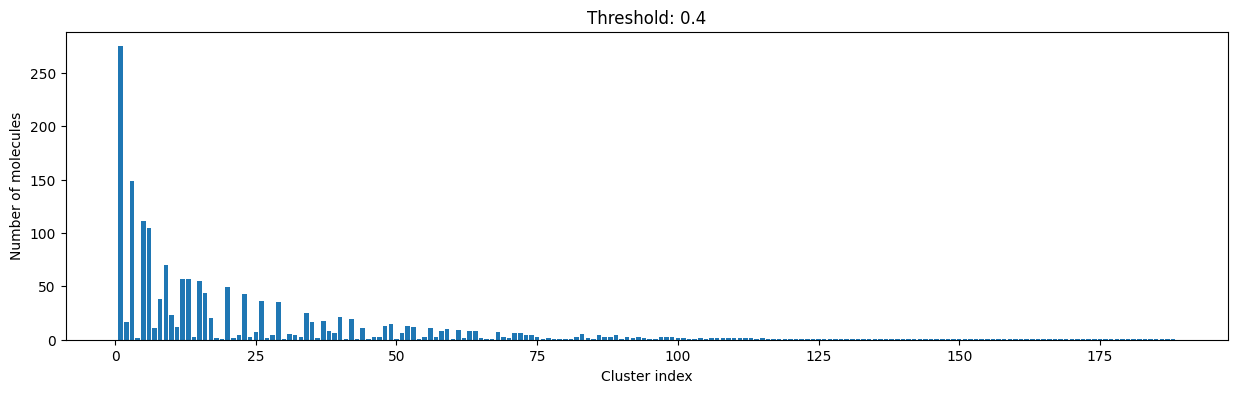

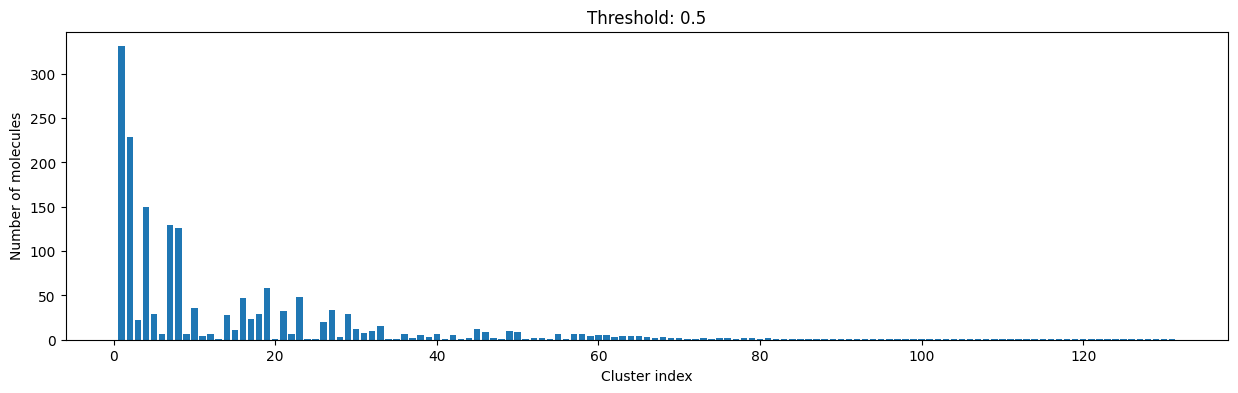

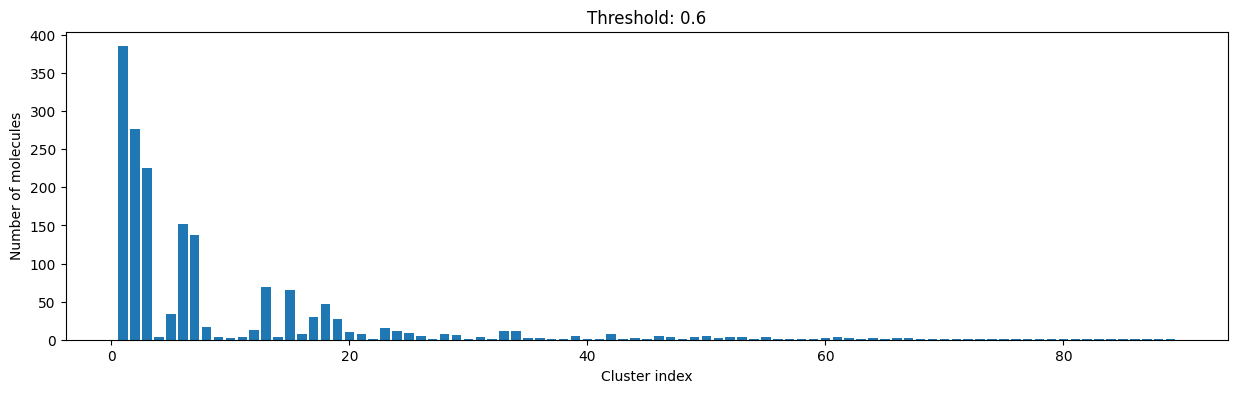

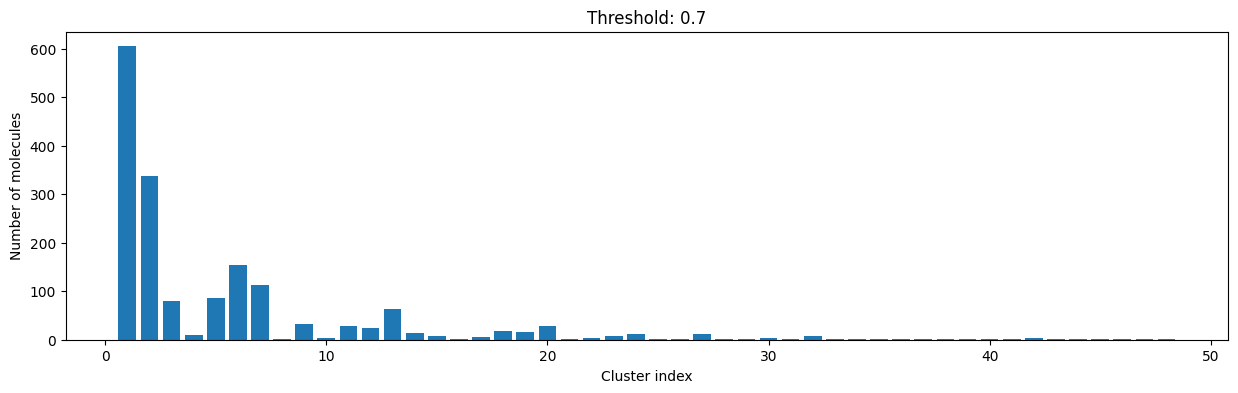

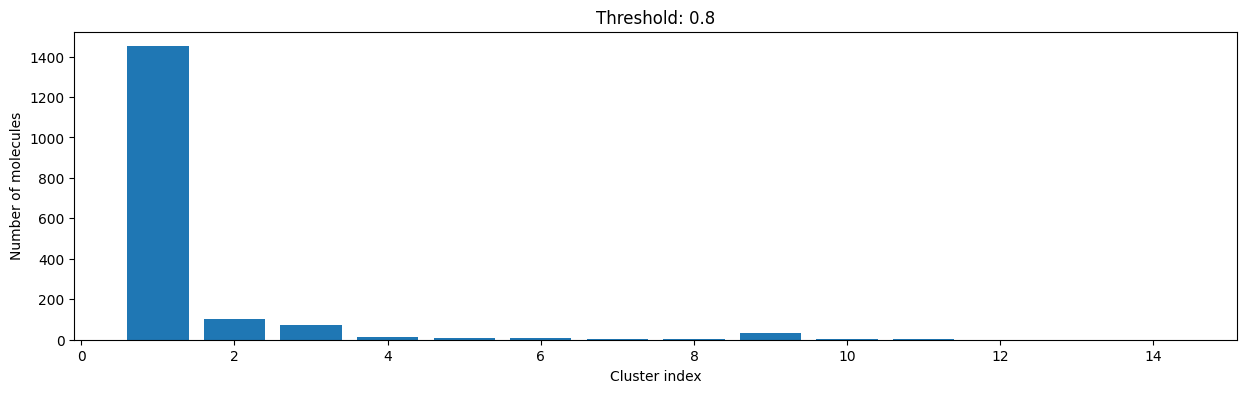

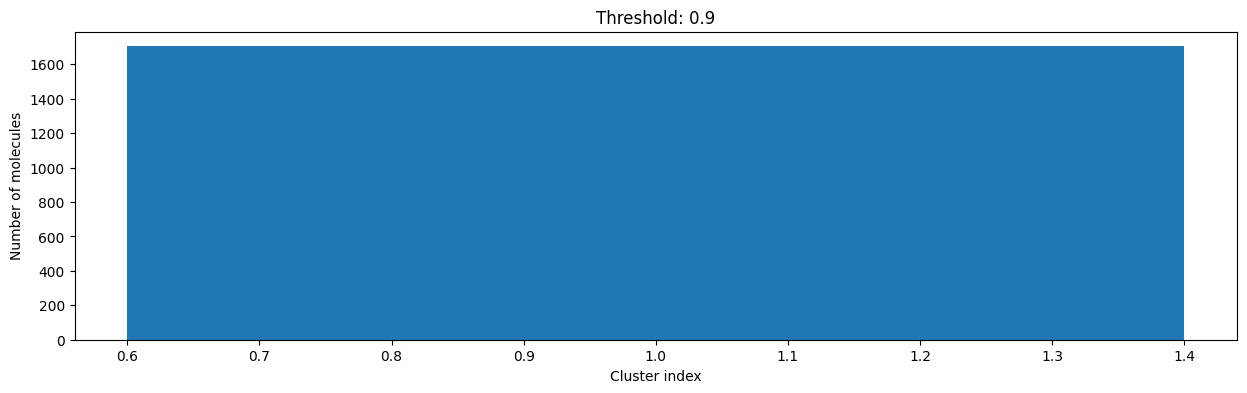

In [59]:
plot_clusters(MorganFingerprints,MorganFingerprints_dice_dist_matrix)

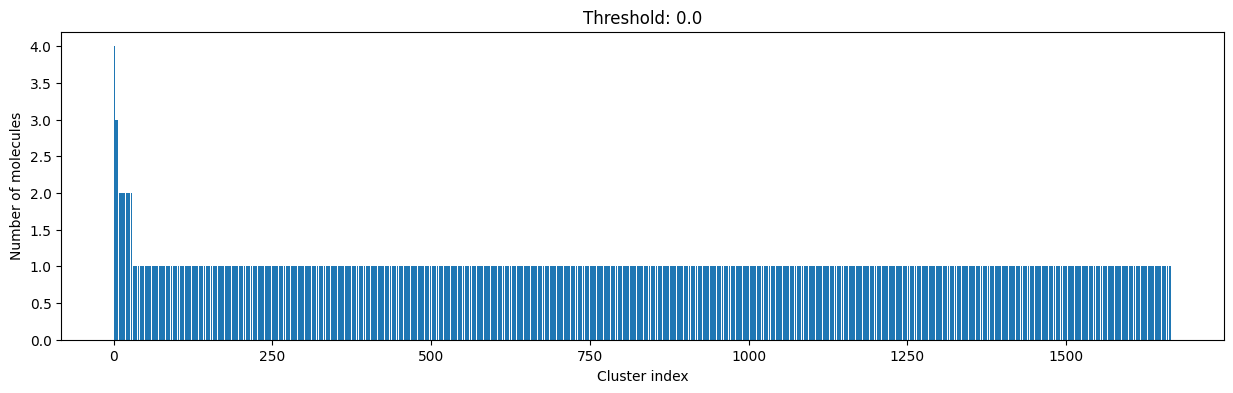

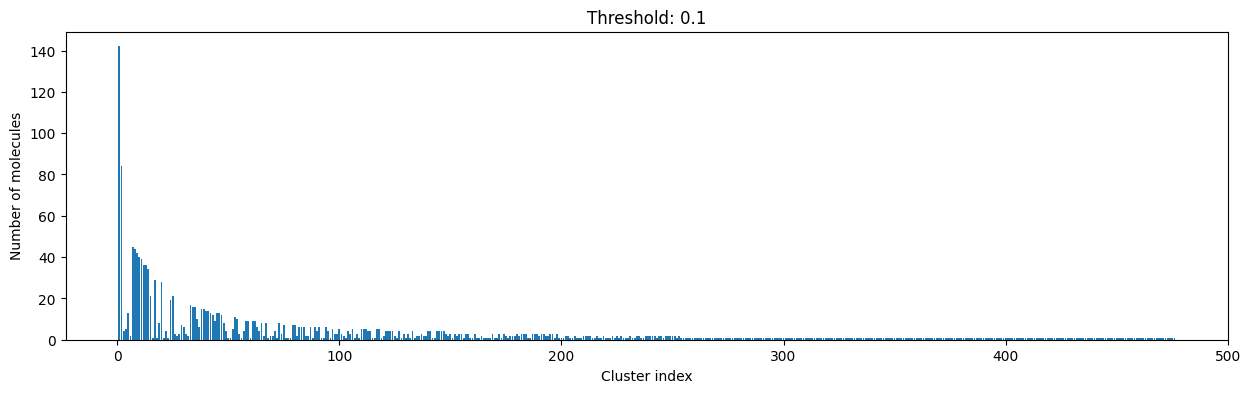

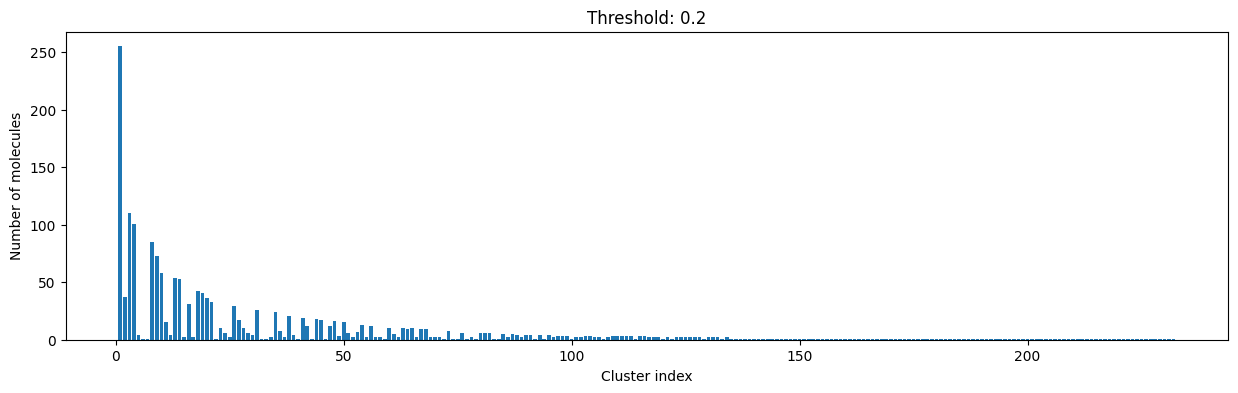

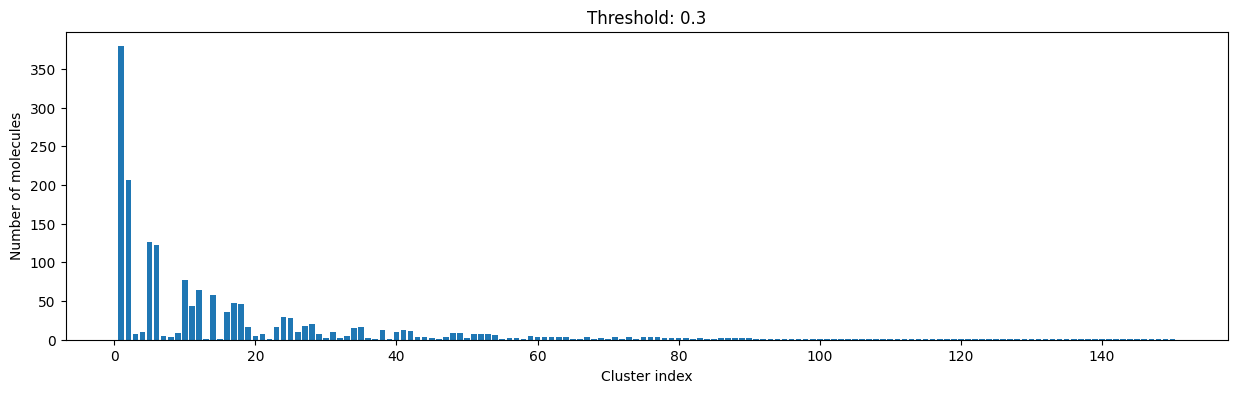

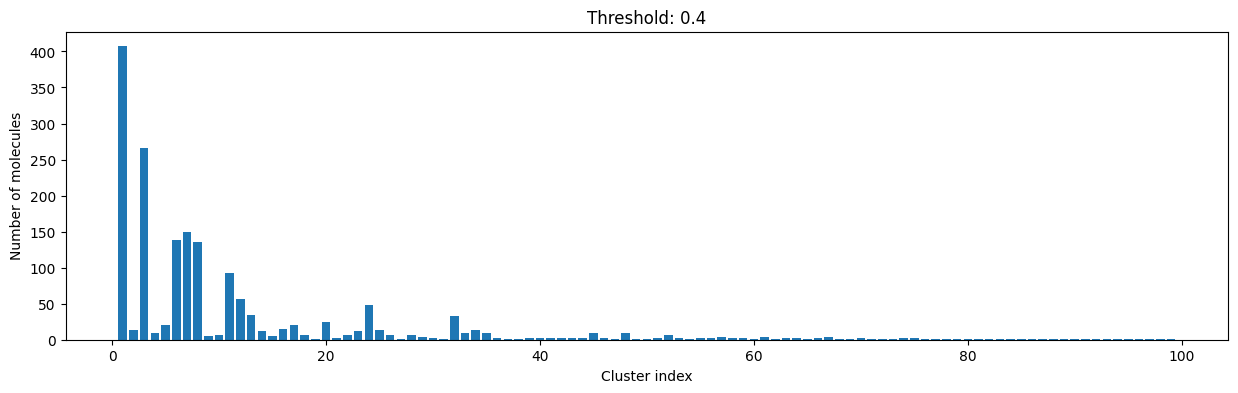

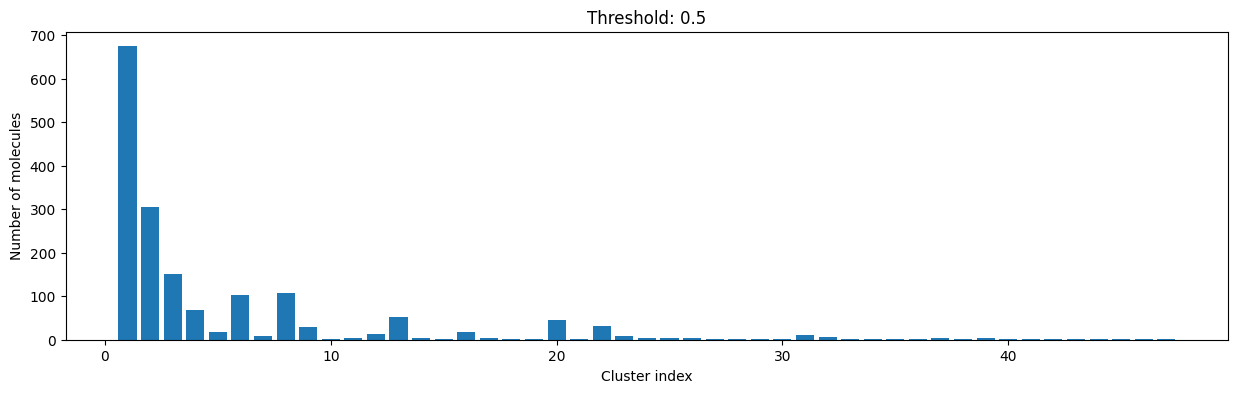

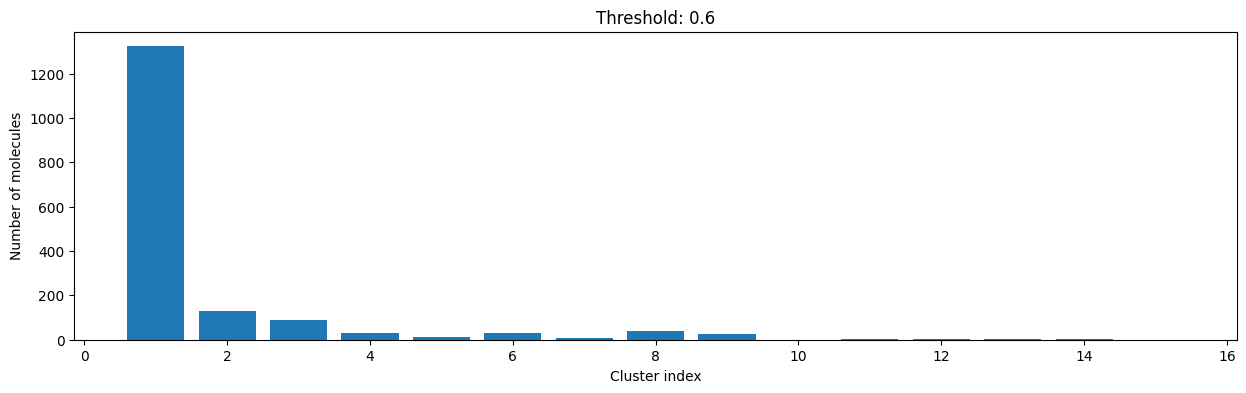

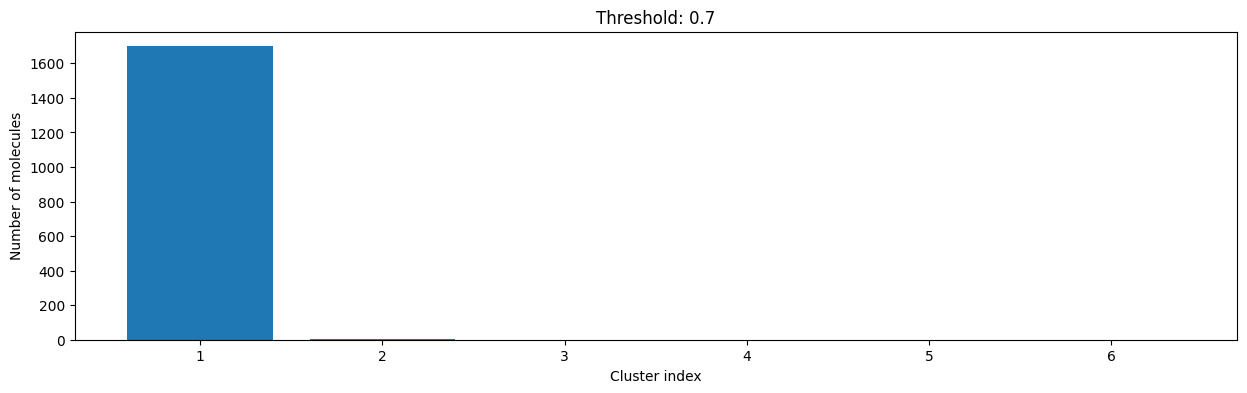

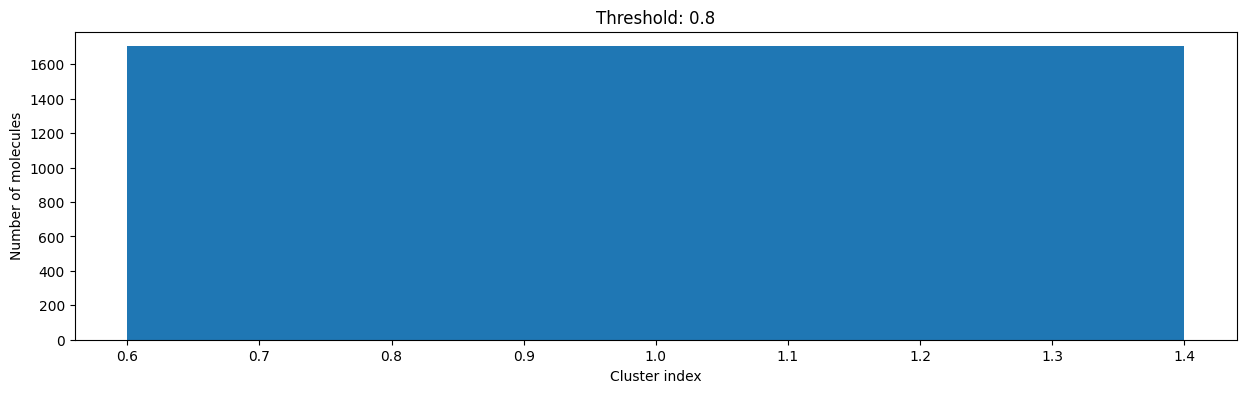

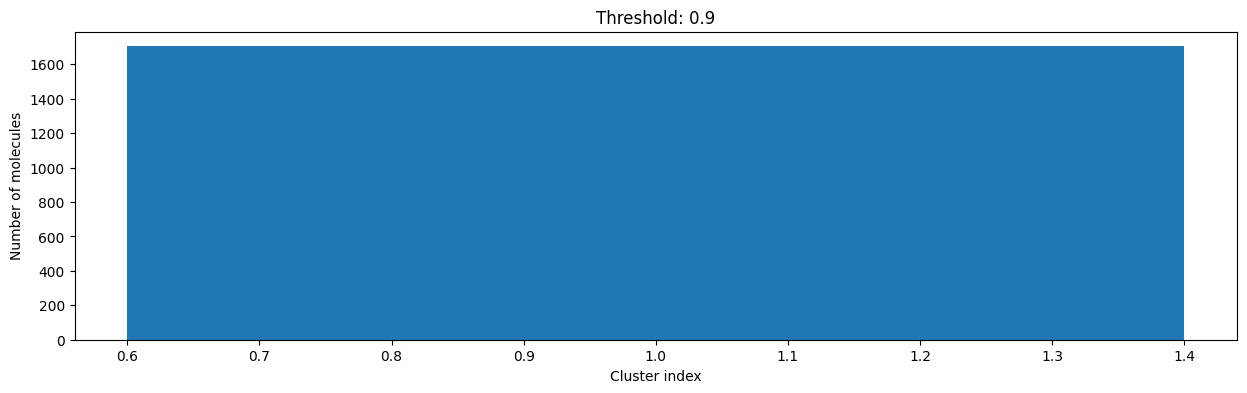

In [60]:
plot_clusters(RDKFingerprints, RDKFingerprints_dice_dist_matrix)

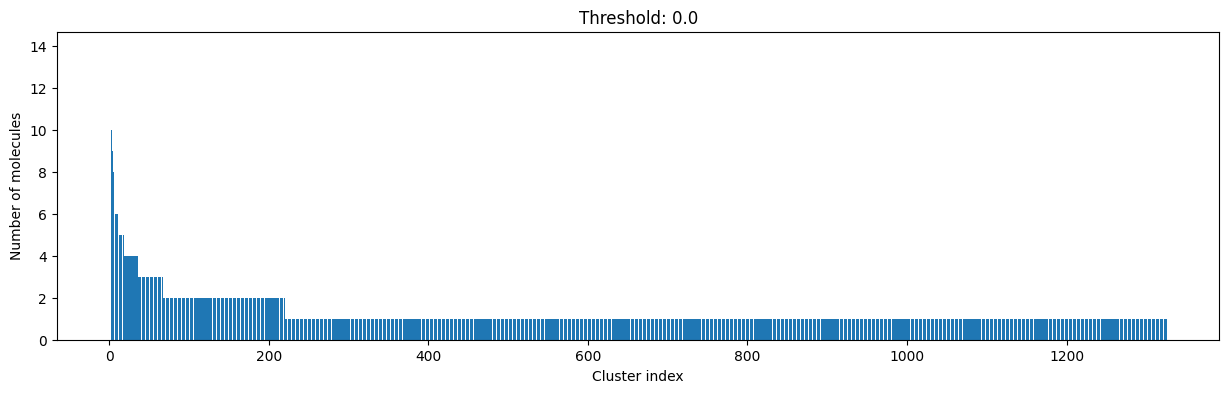

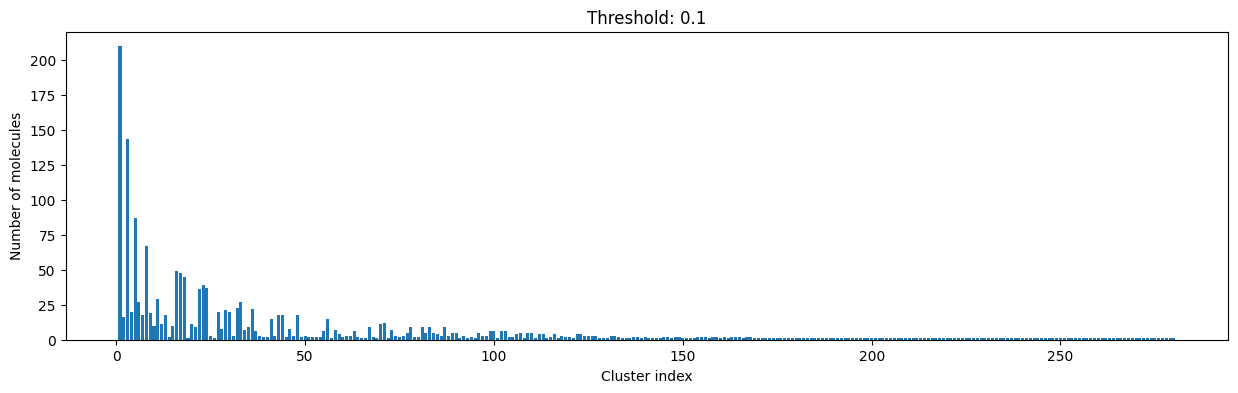

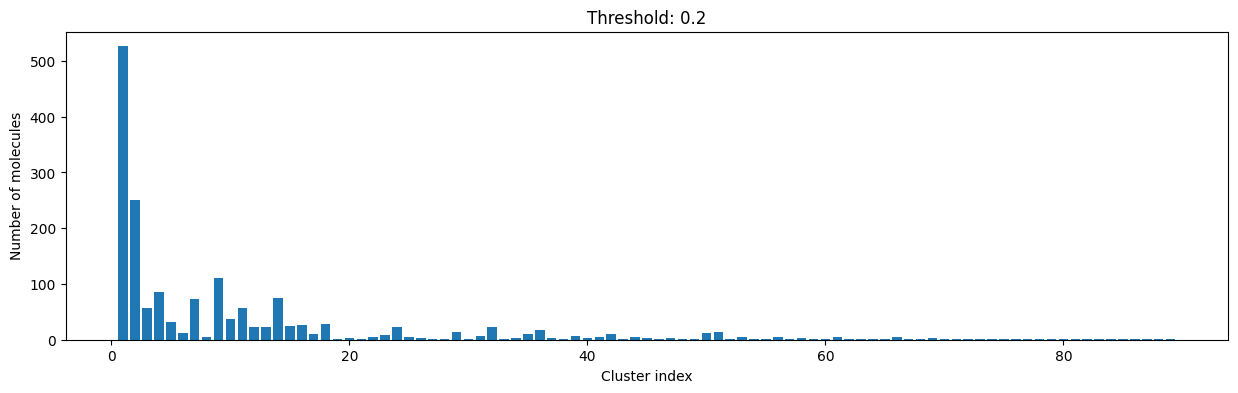

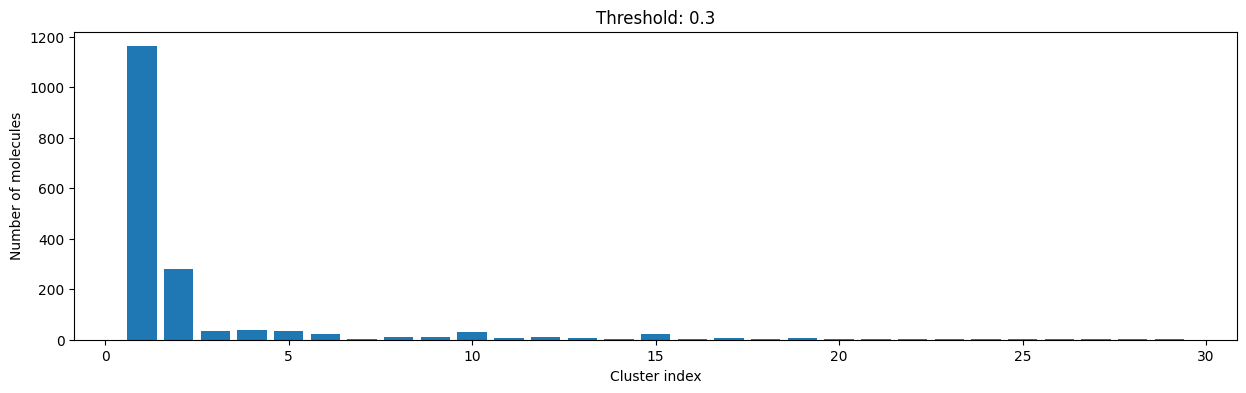

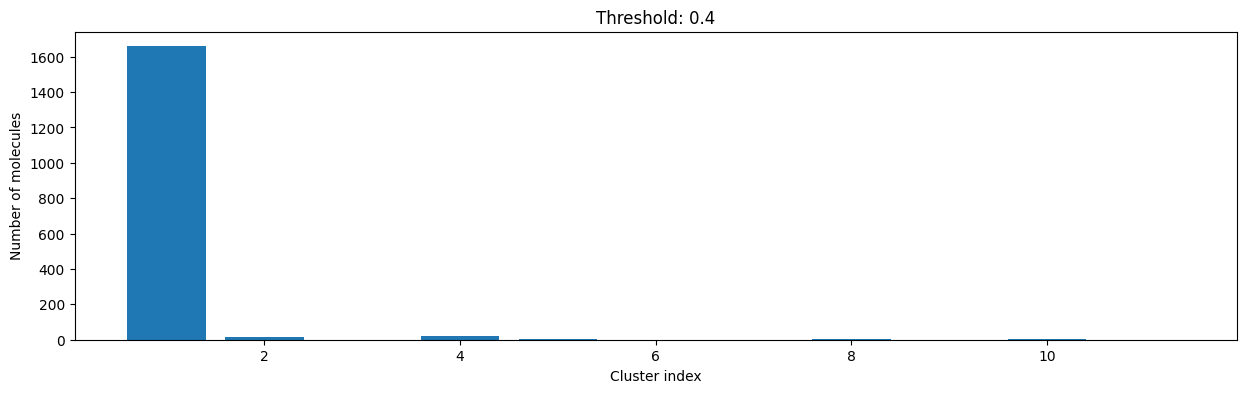

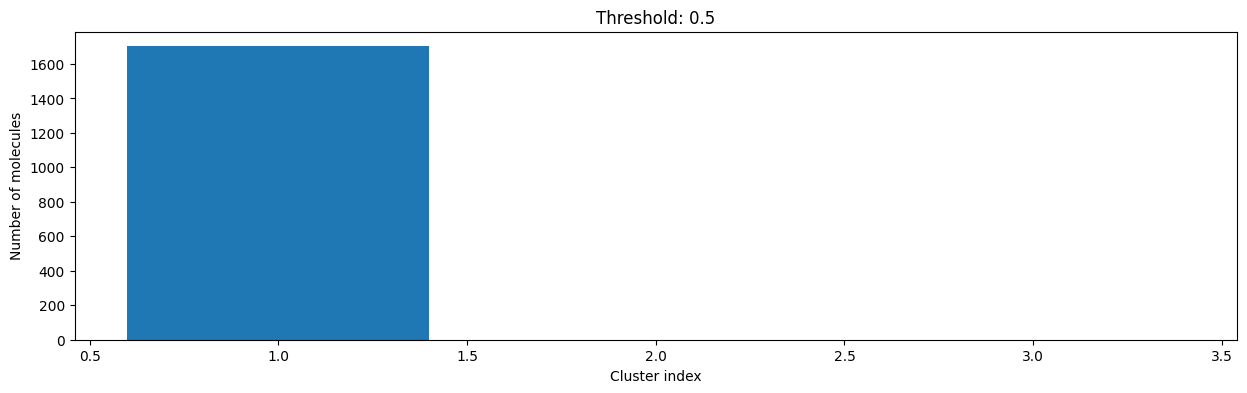

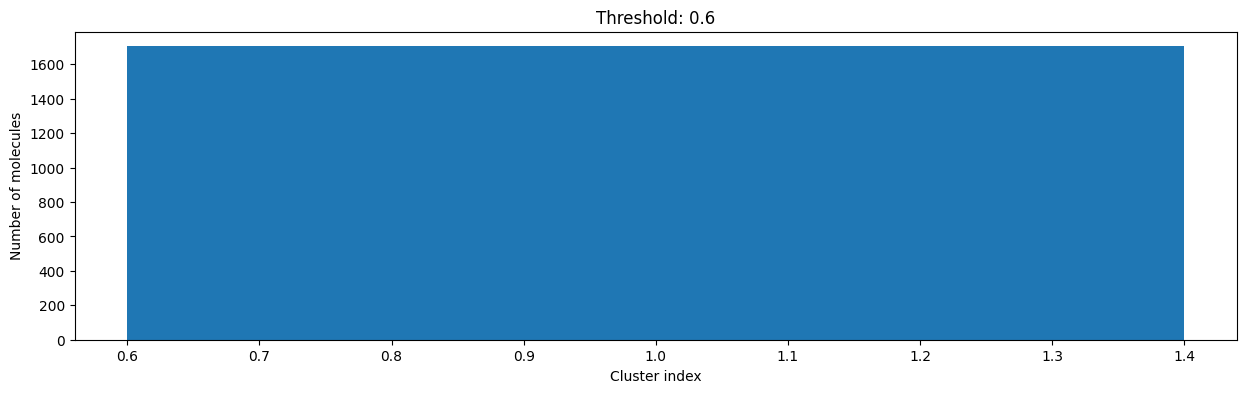

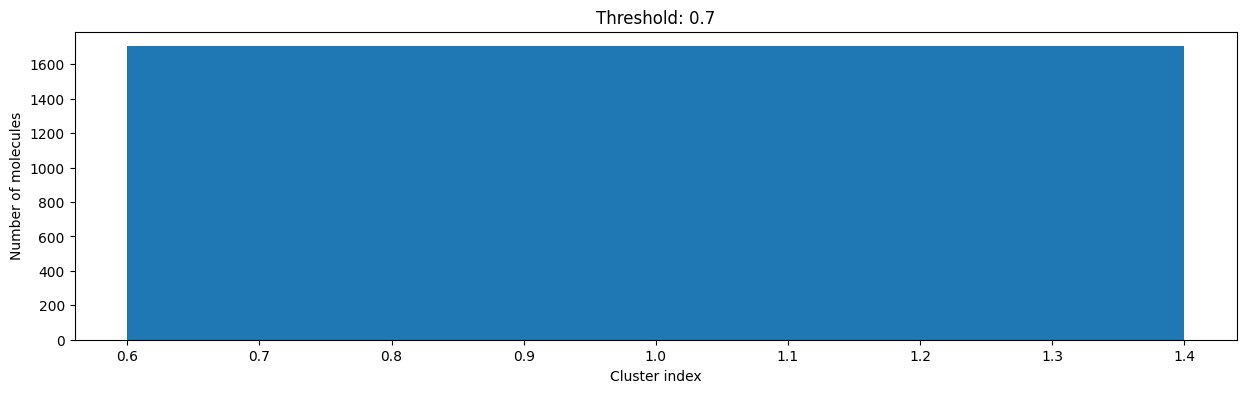

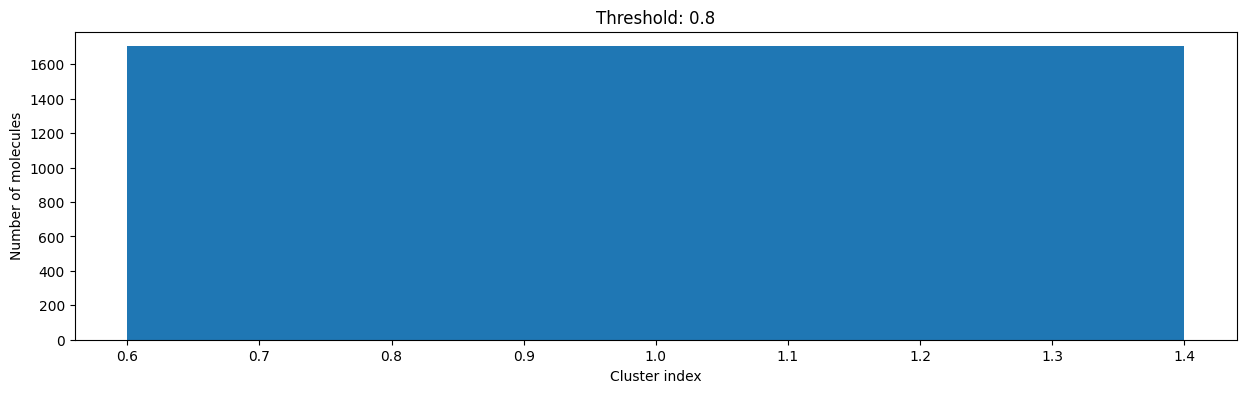

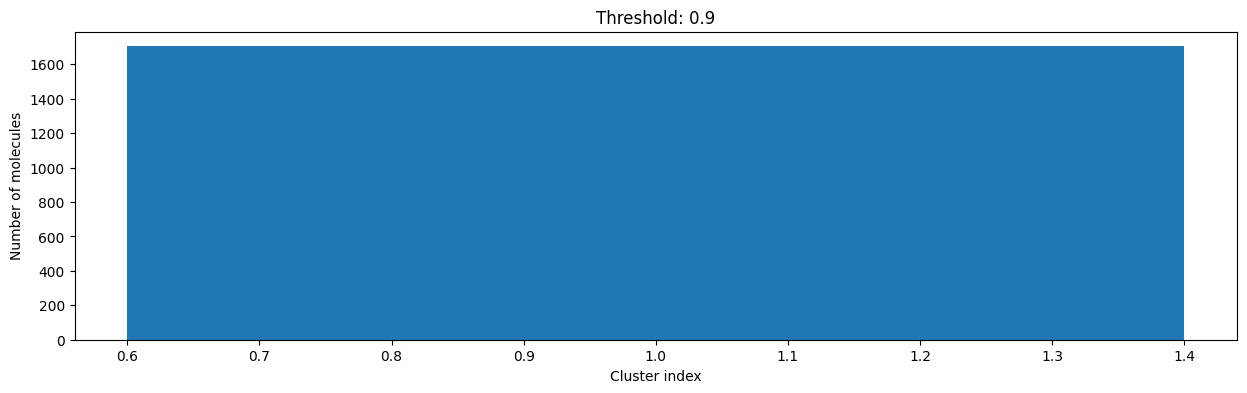

In [61]:
plot_clusters(MACCS, MACCS_dice_dist_matrix)

In [62]:
RDKFingerprints_dice_cluster = cluster(RDKFingerprints, RDKFingerprints_dice_dist_matrix, cutoff=0.1)
MorganFingerprints_dice_cluster = cluster(MorganFingerprints, MorganFingerprints_dice_dist_matrix, cutoff=0.2)
MACCS_dice_cluster = cluster(MACCS, MACCS_dice_dist_matrix, cutoff=0.1)

#Calculating Tanimoto distance of RDKFingerprints inside the clusters

In [63]:
def intra_tanimoto(fps_clusters):
    """Function to compute Tanimoto similarity for all pairs of fingerprints in each cluster"""
    intra_similarity = []
    # Calculate intra similarity per cluster
    for cluster in fps_clusters:
        # Tanimoto distance matrix function converted to similarity matrix (1-distance)
        intra_similarity.append([1 - x for x in tan_distance_matrix(cluster)])
    return intra_similarity

In [74]:
mols = [(Chem.MolFromSmiles(smiles), chembl_id) for chembl_id, smiles in df[["molecule_chembl_id", "std_smiles"]].values]

mol_fps_per_cluster_rdkit = []
for cluster in RDKFingerprints_tan_cluster[:10]:
    mol_val = [mols[i][0] for i in cluster]
    mol_fps = [Chem.RDKFingerprint(m, maxPath=5) for m in mol_val]
    mol_fps_per_cluster.append(mol_fps)


intra_sim_rdkit = intra_tanimoto(mol_fps_per_cluster_rdkit)

Size of subset_intra_sim: 10
Labels: ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8', 'Cluster 9', 'Cluster 10']


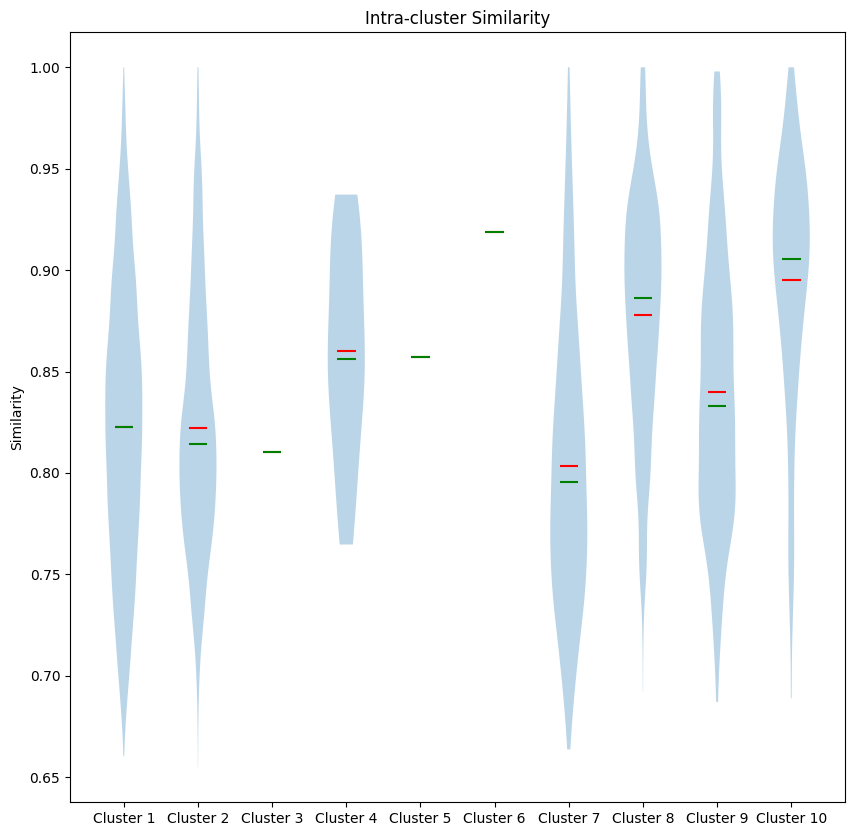

In [75]:
def plot_violin(data, labels):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_title("Intra-cluster Similarity")
    ax.set_ylabel("Similarity")
    plot = ax.violinplot(data, showmedians=True, showmeans=True, showextrema=False)
    plot["cmeans"].set_color("red")
    plot["cmedians"].set_color("green")
    ax.set_xticks(range(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    plt.show()


subset_intra_sim = intra_sim[:10]
print("Size of subset_intra_sim:", len(subset_intra_sim))

# Generate labels for the violin plot
labels = [f"Cluster {i+1}" for i in range(len(subset_intra_sim))]
print("Labels:", labels)

# Plot the violin plot
plot_violin(subset_intra_sim, labels)

Clusters 3,5 and 6 have only a single value in them, thus the violing plot is missing

In [76]:
intra_sim[2], intra_sim[4], intra_sim[5]

([0.810126582278481], [0.8571428571428571], [0.9190207156308852])

In [69]:
def visualize_mcs(molecules, threshold=0.8, save_path=None):
    # Find the Maximum Common Substructure (MCS)
    mcs_result = FindMCS(molecules, threshold=threshold)

    # Get the MCS SMARTS string and create the MCS molecule
    mcs_smarts = mcs_result.smartsString
    mcs_mol = Chem.MolFromSmarts(mcs_smarts)

    # Configure drawing options
    drawing_options = Draw.DrawingOptions()
    drawing_options.atomLabelFontSize = 18
    drawing_options.bondLineWidth = 2.0

    # Draw the MCS molecule
    image = Draw.MolToImage(mcs_mol, options=drawing_options)
    if save_path:
        image.save(save_path)
    # Display the image
    image.show()

In [81]:
molecules_c = [Chem.MolFromSmiles(smiles) for smiles in df['std_smiles']]
molecules = [molecules_c[i] for i in RDKFingerprints_tan_cluster[0]]
visualize_mcs(molecules, threshold=0.8, save_path="rdkit_mcs_image.png")

#Drawing the 12 top molecules in clusters

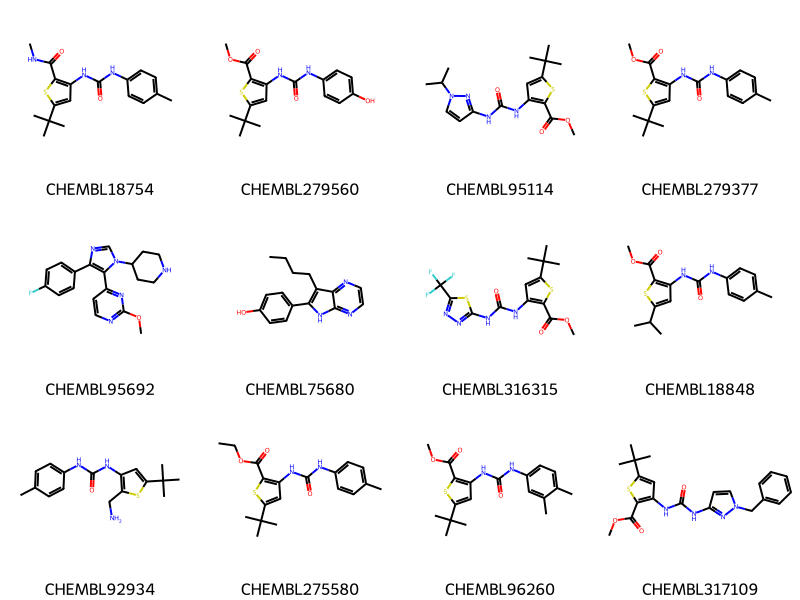

In [77]:
mols = [(Chem.MolFromSmiles(smiles), chembl_id) for _, chembl_id, smiles in df[["molecule_chembl_id", "std_smiles"]].itertuples()]
Draw.MolsToGridImage([mols[i][0] for i in range(min(12, len(mols)))], legends=[mols[i][1] for i in range(min(12, len(mols)))], molsPerRow=4)

#Maximum common substructure using Morgan fingerprints

---



In [97]:
mol_fps_per_cluster_morgan = []
for cluster in MorganFingerprints_tan_cluster[:10]:
    mol_val = [mols[i][0] for i in cluster]
    mol_fps_morg = [AllChem.GetMorganFingerprintAsBitVect(m, 3, nBits=32784, useFeatures=True) for m in mol_val]
    mol_fps_per_cluster_morgan.append(mol_fps_morg)


intra_sim_morgan = intra_tanimoto(mol_fps_per_cluster_morgan)

Size of subset_intra_sim: 10
Labels: ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8', 'Cluster 9', 'Cluster 10']


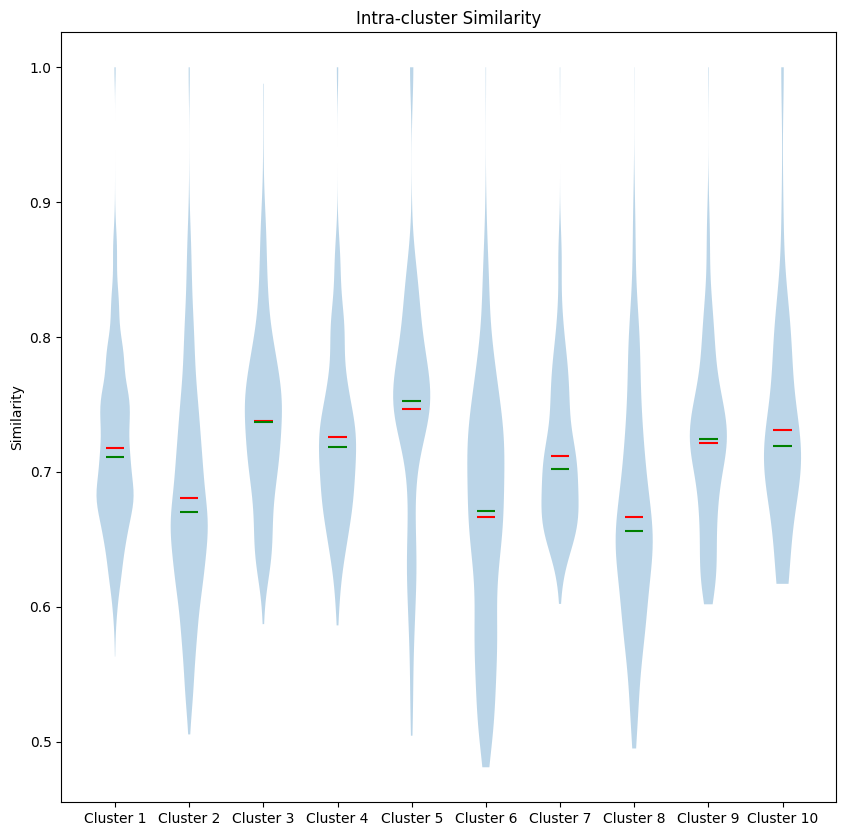

In [99]:
subset_intra_sim_morgan = intra_sim_morgan[:10]
print("Size of subset_intra_sim:", len(subset_intra_sim_morgan))

# Generate labels for the violin plot
labels = [f"Cluster {i+1}" for i in range(len(subset_intra_sim_morgan))]
print("Labels:", labels)

# Plot the violin plot
plot_violin(subset_intra_sim_morgan, labels)

In [104]:
mols = [Chem.MolFromSmiles(smiles) for smiles in df['std_smiles']]
molecules = [mols[i] for i in MorganFingerprints_tan_cluster[0]]
morgan_mcs = visualize_mcs(molecules, threshold=0.8, save_path="morgan_mcs_image.png")

# Maximum common substructure using MACCS fingerprints


In [103]:
mol_fps_per_cluster_maccs = []
for cluster in MACCS_tan_cluster[:10]:
    mol_val = [mols[i][0] for i in cluster]
    mol_fps_maccs = [MACCSkeys.GenMACCSKeys(m) for m in mol_val]
    mol_fps_per_cluster_maccs.append(mol_fps_maccs)


intra_sim_morgan = intra_tanimoto(mol_fps_per_cluster_maccs)

Size of subset_intra_sim: 10
Labels: ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8', 'Cluster 9', 'Cluster 10']


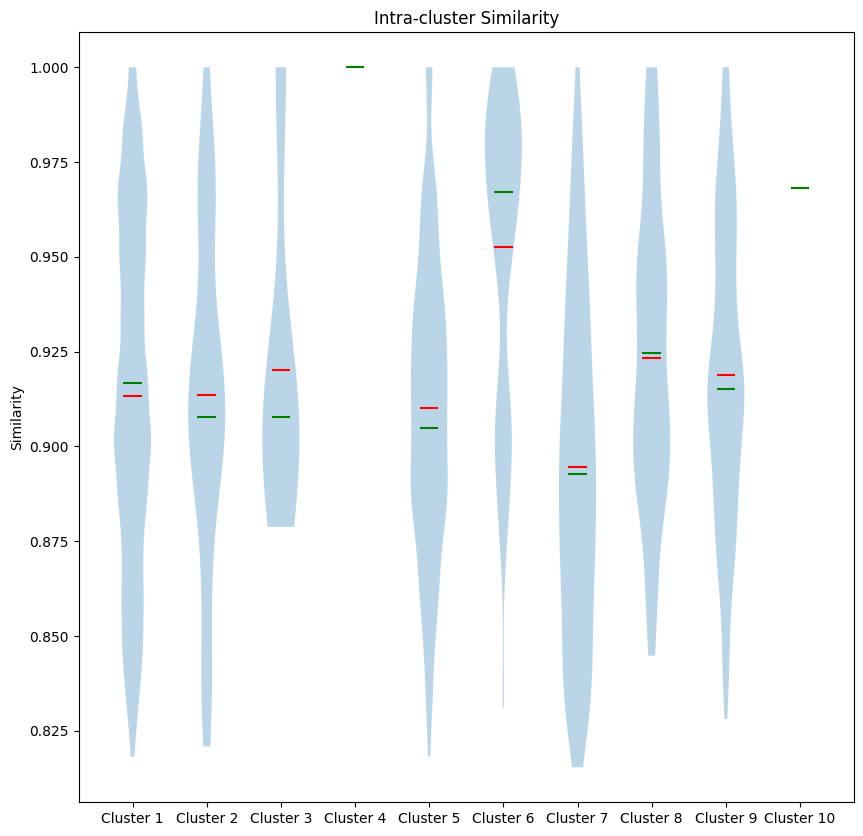

In [102]:
subset_intra_sim_MACCS = intra_sim_morgan[:10]
print("Size of subset_intra_sim:", len(subset_intra_sim_MACCS))

# Generate labels for the violin plot
labels = [f"Cluster {i+1}" for i in range(len(subset_intra_sim_MACCS))]
print("Labels:", labels)

# Plot the violin plot
plot_violin(subset_intra_sim_MACCS, labels)

In [105]:
mols = [Chem.MolFromSmiles(smiles) for smiles in df['std_smiles']]
molecules = [mols[i] for i in MACCS_tan_cluster[0]]
maccs_mcs = visualize_mcs(molecules, threshold=0.8, save_path="maccs_mcs_image.png")

#Plotting 3 different maximum common substructures

In [108]:
rdkit_img = mpimg.imread("rdkit_mcs_image.png")
morgan_img = mpimg.imread("morgan_mcs_image.png")
maccs_img = mpimg.imread("maccs_mcs_image.png")

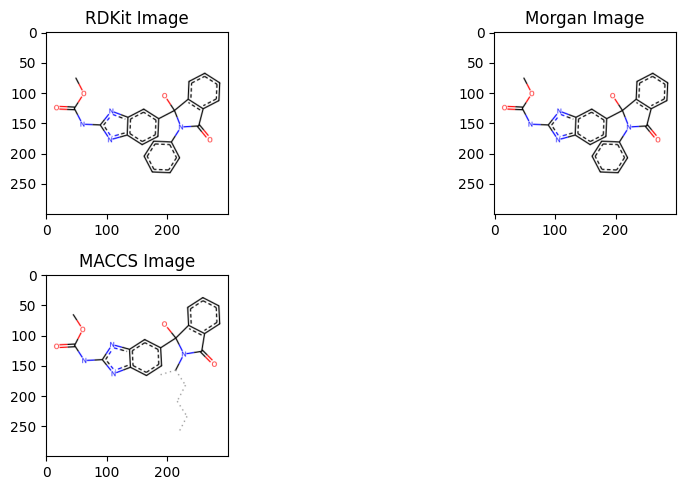

In [118]:
def plot_subplots(images, titles, figsize=(10, 5)):
    num_plots = len(images)
    rows = (num_plots + 1) // 2

    plt.figure(figsize=figsize)

    for i in range(num_plots):
        plt.subplot(rows, 2, i + 1)
        plt.title(titles[i])
        plt.imshow(images[i])

    plt.tight_layout()
    plt.show()

images = [rdkit_img, morgan_img, maccs_img]
titles = ["RDKit Image", "Morgan Image", "MACCS Image"]
plot_subplots(images, titles)